## ACLED Data Processing Pipeline for Conflict Event Extraction

## Overview

This particular notebook presents a data processing pipeline developed for transforming raw ACLED (Armed Conflict Location & Event Data) records into structured datasets suitable for machine learning applications. The work focuses specifically on conflict events occurring across Eastern Europe, Central Europe, and the Baltic States, with particular emphasis on modern warfare patterns including the ongoing Ukraine-Russia conflict.

**Primary objective**: To develop and validate a robust field extraction system capable of parsing unstructured conflict reports into fourteen structured data fields, creating a high-quality training dataset for fine-tuning small language models on Apple Silicon hardware using MLX.

## Methodology

### Data Scope and Geographic Focus

The pipeline processes ACLED records from thirteen European countries, creating a regionally coherent dataset that captures modern conflict dynamics across:

- **Eastern Europe**: Ukraine, Russia, Belarus, Moldova, Bulgaria, Romania
- **Central Europe**: Poland, Czech Republic, Hungary, Slovakia  
- **Baltic States**: Lithuania, Latvia, Estonia

This geographic constraint ensures consistency whilst concentrating analysis on regions experiencing significant security developments, particularly in the context of interstate conflict and cross-border operations.

### Technical Implementation

#### Quality Assessment Framework

A ten-point scoring system specifically calibrated for conflict event data, evaluating:

- Structural indicators (temporal markers, geographic references, actor identification)
- Information density (casualty figures, weapon specifications, infrastructure details)
- Content coherence (sourcing, date precision, event specificity)

#### Advanced Field Extraction System

The core extraction module employs pattern recognition to identify:

- **Temporal and geographic intelligence**: Multi-format date parsing and cross-border operation handling
- **Actor detection**: Ten-tier hierarchical system covering military forces, protest groups, and security services
- **Modern weapons recognition**: Contemporary systems including FPV drones, Shahed drones, HIMARS, and calibre-specific artillery
- **Infrastructure impact assessment**: Eight critical categories from power grid disruption to military installations

#### Cross-Border Intelligence

Special handling for interstate operations, including:

- Automatic attribution of Belgorod region events to Russia
- Detection of Ukrainian strikes on Russian territory and vice versa
- Proper classification of cross-border military operations as interstate conflict

### Validation and Quality Assurance

Multi-stage validation ensures data integrity through:

- Field completeness verification across all fourteen target fields
- Geographic and actor consistency checks
- Numeric range validation for casualty figures
- Content quality thresholds preventing low-information samples from proceeding

## Results and Performance

### Test Suite Validation

Comprehensive testing across six diverse conflict scenarios achieved:

- **100% individual field accuracy** across 36 specific tests
- **100% complete case success** (5/5 test cases fully passed)
- **100% validation success** with robust error handling

### Processing Outcomes

From an initial dataset of 309.974 ACLED records:

- **Quality filtering**: Retained records meeting structural and content thresholds
- **Field extraction**: Successfully processed samples with comprehensive field coverage
- **Strategic selection**: Created two curated subset optimised for machine learning applications

### Geographic Coverage

In conclusion, the system demonstrates reliable country detection across all thirteen target nations, with particular strength in handling complex conflict scenarios.

### Library Dependencies

The following libraries are used throughout the project for processing, evaluation, and visualisation:

- **`pandas`** – For loading, filtering, and exporting structured data
- **`numpy`** – Handles numerical operations
- **`json`** – Reads and writes JSON data
- **`os`** – Manages file paths and directories
- **`re`** – Supports regular expression matching
- **`random`** – Enables reproducible sampling and shuffling
- **`datetime`** – Adds timestamps for logs and metadata
- **`defaultdict`** – Helps with counting and grouping results
- **`matplotlib.pyplot`** – Creates charts and visual summaries

In [146]:
import pandas as pd
import numpy as np
import json
import os
import re
import random
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

print("Libraries imported successfully. Environment ready for ACLED data processing and analysis.")

Libraries imported successfully. Environment ready for ACLED data processing and analysis.


### Geographic Filtering and Data Loading

The following section implements the primary data ingestion and regional filtering operations, applying systematic geographic constraints to ensure analytical coherence and focus on contemporary European security dynamics.

#### Target Geographic Scope

The pipeline processes ACLED records exclusively from thirteen carefully selected European nations, creating a regionally coherent dataset optimised for modern conflict analysis:

**Eastern Europe**
- **Ukraine** — 243.794 records (78.6%) — Primary focus given ongoing interstate conflict
- **Russia** — 39.280 records (12.7%) — Essential for cross-border operations analysis
- **Belarus** — 4.085 records — Regional security dynamics
- **Moldova** — 2.013 records — Including Transnistrian separatist activities
- **Bulgaria** — 4.430 records — Southeastern European stability
- **Romania** — 3.101 records — NATO frontier dynamics

**Central Europe**
- **Poland** — 8.231 records — Critical NATO ally and Ukrainian support hub
- **Czech Republic** — 1.509 records — Central European stability patterns
- **Hungary** — 1.273 records — Regional political developments
- **Slovakia** — 1.046 records — Visegrad Group dynamics

**Baltic States**
- **Lithuania** — 517 records — Russian border security concerns
- **Latvia** — 291 records — Ethnic minority dynamics
- **Estonia** — 404 records — Digital warfare and hybrid threats

#### Data Processing Results

The geographic filtering yields a comprehensive dataset spanning multiple conflict types and temporal periods:

- **Total dataset scope**: 309.974 conflict-event records from the ACLED database
- **Temporal coverage**: Multi-year span capturing evolving security patterns from traditional protests to modern interstate warfare
- **Data integrity**: 100% retention of records containing substantive textual notes suitable for downstream natural language processing

#### Field Extraction Targets

The pipeline extracts fourteen structured fields designed to capture the essential dimensions of contemporary conflict events:

**Core identifiers**: `event_date`, `country`, `location`, `event_type`

**Actor analysis**: `actor_1`, `actor_2`

**Impact assessment**: `fatalities`, `civilian_casualties`, `property_damage`

**Technical intelligence**: `weapons_mentioned`, `casualty_type`, `attack_method`

**Strategic analysis**: `disorder_type`, `infrastructure_disruption`

In [147]:
TARGET_COUNTRIES = [
    "Ukraine", "Russia", "Belarus", "Moldova", "Bulgaria", "Romania",
    "Poland", "Czech Republic", "Hungary", "Slovakia",                  
    "Lithuania", "Latvia", "Estonia"                                    
]

# Define TARGET_FIELDS consistently, especially if planned to add more fields in the future
TARGET_FIELDS = [
    'event_date', 'country', 'location', 'event_type',
    'actor_1', 'actor_2', 'fatalities', 'civilian_casualties',
    'property_damage', 'weapons_mentioned', 'casualty_type', 'attack_method',
    'disorder_type', 'infrastructure_disruption'
]

print("Initialising ACLED data loading and filtering process")
print(f"Target country count: {len(TARGET_COUNTRIES)}")
print(f"Target fields count: {len(TARGET_FIELDS)}\n")

export_dir = "ACLED_data_export"
os.makedirs(export_dir, exist_ok=True)
print(f"Export directory: {export_dir}")

try:
    df = pd.read_csv("Europe-Central-Asia_2018-2025_July.csv", low_memory=False)
    print(f"Loaded {len(df):,} total records.")

    df = df[df["country"].isin(TARGET_COUNTRIES)].copy()
    print(f"Filtered to {len(df):,} records from target countries.")

    # Remove entries without notes
    df = df[df["notes"].notna()].copy()
    print(f"Retained {len(df):,} records with non-null notes.")

    # Parse event dates
    df["event_date"] = pd.to_datetime(df["event_date"])

    print("\nCountry distribution:")
    for country, count in df["country"].value_counts().items():
        pct = (count / len(df)) * 100
        print(f"  {country:<18} {count:>6,} ({pct:>5.1f}%)")

    print(f"\nDate range: {df['event_date'].min().date()} to {df['event_date'].max().date()}")
    data_source = "ACLED"

except FileNotFoundError:
    print("ACLED dataset not found. Initialising fallback: synthetic dataset.\n")

    # Synthetic fallback for testing or development
    synthetic_data = []
    for i in range(2000):
        country = TARGET_COUNTRIES[i % len(TARGET_COUNTRIES)]
        date = f"2024-{(i % 12) + 1:02d}-{(i % 28) + 1:02d}"
        note = (
            f"On {date}, government forces responded to a security incident in {country}. "
            f"Local authorities confirmed the situation was under control."
        )
        synthetic_data.append({
            "notes": note,
            "country": country,
            "event_date": date
        })

    df = pd.DataFrame(synthetic_data)
    df["event_date"] = pd.to_datetime(df["event_date"])
    print(f"Created synthetic dataset with {len(df):,} records.")
    data_source = "synthetic"

print(f"\nDataset ready: {len(df):,} records from {df['country'].nunique()} countries.")

Initialising ACLED data loading and filtering process
Target country count: 13
Target fields count: 14

Export directory: ACLED_data_export
Loaded 527,211 total records.
Filtered to 309,974 records from target countries.
Retained 309,974 records with non-null notes.

Country distribution:
  Ukraine            243,794 ( 78.6%)
  Russia             39,280 ( 12.7%)
  Poland              8,231 (  2.7%)
  Bulgaria            4,430 (  1.4%)
  Belarus             4,085 (  1.3%)
  Romania             3,101 (  1.0%)
  Moldova             2,013 (  0.6%)
  Czech Republic      1,509 (  0.5%)
  Hungary             1,273 (  0.4%)
  Slovakia            1,046 (  0.3%)
  Lithuania             517 (  0.2%)
  Estonia               404 (  0.1%)
  Latvia                291 (  0.1%)

Date range: 2018-01-01 to 2025-07-04

Dataset ready: 309,974 records from 13 countries.


### Quality Assessment of Conflict Notes

Each ACLED note undergoes an extensive quality assessment using a ten-point scoring system specifically calibrated for conflict-event data. The assessment ensures that linguistically and semantically adequate records proceed to field extraction, maintaining maximum dataset coverage.

### Assessment Criteria

**Structural Validation**

- **Minimum length**: At least 50 characters with substantial content
- **Readability**: Plain-text encoding without formatting errors
- **Content structure**: Presence of structural indicators (*on*, *at*, *in*, *during*, *according*, *reported*)

**Information-Density Scoring**

- **Temporal precision**: Full-date formats (e.g. "19 April 2025") receive maximum points
- **Geographic specificity**: Multiple location mentions and regional identifiers
- **Actor attribution**: Military, police, or protest-group identification
- **Event details**: Casualty numbers, damage reports, and weapon specifications

#### Scoring System (0–10 Scale)

- **Length scoring (0–3 points)**: Progressive scoring from 50 to 400+ characters
- **Content quality (0–3 points)**: Bonus for precise dates, sourcing, and casualty figures
- **Information density (0–4 points)**: Geographic diversity, actor specificity, and event-detail richness

In [148]:
def assess_note_quality(text):
    """
    Quality assessment with realistic scoring criteria for ACLED data.
    Returns (passes_threshold, quality_score) where quality_score is 0-10.
    """
    if pd.isna(text) or not isinstance(text, str):
        return False, 0.0

    text = text.strip()
    if not text:
        return False, 0.0
        
    text_lower = text.lower()

    # Structural validation for ACLED data
    checks = {
        "sufficient_length": len(text) >= 50,
        "has_content": bool(text and text != ""),
        "readable": not bool(re.search(r"[^\x00-\x7F]{20,}", text)),  # More lenient
        "has_structure": bool(re.search(r"\b(on|at|in|during|according|reported|confirmed)\b", text_lower)),  
        "has_location": bool(re.search(r"\b[A-Z][a-z]{2,}\b", text)),  # Shorter names are allowed
        "has_actors": bool(re.search(r"\b(forces|police|military|troops|protesters|rebels|government)\b", text_lower)),
        "has_temporal": bool(re.search(r"\b(january|february|march|april|may|june|july|august|september|october|november|december|\d{1,2}/\d{1,2}/\d{4})\b", text_lower)),
        "has_numbers": bool(re.search(r"\b\d+\b", text)),
        "has_action": bool(re.search(r"\b(attack|fired|killed|injured|protest|clash|explosion|reported)\b", text_lower))
    }

    # Require at least 4 checks to pass
    passes_basic = sum(checks.values()) >= 4

    # Scoring system (0-10 scale)
    score = 0.0

    # Length scoring (0-3 points)
    if len(text) >= 400:
        score += 3.0
    elif len(text) >= 200:
        score += 2.5
    elif len(text) >= 100:
        score += 2.0
    elif len(text) >= 50:
        score += 1.5

    # Content quality (0-3 points)
    if re.search(r"\b\d{1,2}\s+(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b", text):
        score += 1.0
    if re.search(r"\b(according to|reported|confirmed by|sources said)\b", text_lower):
        score += 1.0
    if re.search(r"\b\d+\s+(killed|dead|injured|wounded|casualties)\b", text_lower):
        score += 1.0

    # Geographic and actor specificity (0-2 points)
    location_matches = re.findall(r"\b[A-Z][a-z]{2,}\b", text)
    location_count = len(set(location_matches)) if location_matches else 0
    if location_count >= 2:
        score += 1.0
    elif location_count >= 1:
        score += 0.5

    actor_keywords = ["forces", "police", "military", "troops", "protesters", "government", "officials"]
    actor_count = sum(1 for word in actor_keywords if word in text_lower)
    if actor_count >= 2:
        score += 1.0
    elif actor_count >= 1:
        score += 0.5

    # Information density (0-2 points)
    event_indicators = ["attack", "bombing", "shooting", "protest", "clash", "strike", "explosion", "fired"]
    event_count = sum(1 for term in event_indicators if term in text_lower)
    if event_count >= 2:
        score += 1.0
    elif event_count >= 1:
        score += 0.5

    detail_indicators = ["casualties", "damage", "weapons", "injuries", "arrested", "hospital", "school"]
    detail_count = sum(1 for indicator in detail_indicators if indicator in text_lower)
    if detail_count >= 2:
        score += 1.0
    elif detail_count >= 1:
        score += 0.5

    return passes_basic, min(score, 10.0)

### Advanced Field Extraction System

The extraction system aims to transform unstructured ACLED conflict reports into 14 structured fields through sophisticated pattern recognition, contextual analysis, and robust error handling specifically calibrated for contemporary Eastern European conflict scenarios.

### Core Extraction Capabilities

#### Temporal and Geographic Intelligence

- **Multi-format date recognition**: Processes eight distinct date patterns including European formats (`15 March 2024`), contextual phrases (`On 19 April 2025`), and numeric variations (`15/03/2024`, `2024-03-15`)
- **Cross-border operation handling**: Correctly attributes events across national boundaries (e.g., Ukrainian strikes in Belgorod → Russia)
- **Advanced location extraction**: Six-tier pattern system detecting cities, regions, and facilities whilst filtering 60+ false positives
- **Geographic context preservation**: Maintains accuracy for complex scenarios like "Russian forces operating on Ukrainian soil"

#### Country Detection with Cross-Border Intelligence

- **Highest priority**: Belgorod and Russian border regions (Kursk, Bryansk, Voronezh, Rostov) automatically attributed to Russia
- **Cross-border operations**: "Ukrainian drones struck Belgorod region" correctly attributed to Russia as event location
- **Three-tier system**: Border regions → cross-border patterns → standard country detection
- **Comprehensive coverage**: Thirteen target countries with region-specific patterns and city identification

#### Hierarchical Actor Detection System

- **Ten-tier primary actor recognition**: From action-context patterns ("Ukrainian forces launched") to generic fallbacks
- **Twelve-tier secondary actor targeting**: Identifies forces under attack through targeting patterns and casualty analysis
- **Specific unit types**: Territorial defence, marines, national guard, air forces, partisans, and militia groups
- **Protest actors**: Demonstrators, activists, opposition groups, trade unions, and civil society
- **Regional military forces**: All thirteen countries covered with specific force identification

#### Modern Weapons and Equipment Recognition

- **Contemporary systems**: FPV drones, Shahed drones, HIMARS, Iskander-M missiles, FAB aerial bombs, Lancet drones
- **Calibre-specific detection**: 120mm mortars, 152mm artillery, 82mm mortars with priority over generic terms
- **Vehicle and aircraft identification**: Su-30 jets, Mi-8 helicopters, T-72 tanks, BMP-2 vehicles, Pantsir-S1 systems
- **Hierarchical specificity**: From generic "drones" to specific "Ka-52 helicopters" and "bomber drones"

#### Infrastructure Impact Assessment

- **Eight critical categories**: Power grid, medical services, transportation, communications, water supply, education, energy facilities, military infrastructure
- **Damage pattern recognition**: 30+ specific patterns from "power stations damaged" to "UAV equipment destroyed"
- **Modern warfare targets**: Electronic warfare stations, satellite terminals, industrial facilities, chemical plants

#### Advanced Disorder Type Classification

- **Interstate conflict priority**: Automatic classification for cross-border military operations between Russian and Ukrainian forces
- **Ethnic conflict detection**: Specialised patterns for "ethnic tensions escalated" and minority community conflicts
- **Protest versus civil unrest distinction**: Differentiates peaceful demonstrations from violent riots
- **Separatist conflict identification**: NAF forces, breakaway regions, pro-Russian separatists

### Quality Assurance Features

#### Robust Error Handling

- **Graceful degradation**: Processes malformed text without system failure
- **Field completeness guarantee**: All fourteen fields present with "unknown" fallback where appropriate
- **Exception management**: Comprehensive try-catch blocks with detailed error logging

#### Cross-Border Intelligence Implementation

- **Belgorod attribution**: Special handling ensures all Belgorod region mentions correctly attributed to Russia
- **Interstate classification**: Automatic disorder_type assignment for cross-border military operations
- **Actor-geography consistency**: Validates actor actions against geographic context

In [149]:
def extract_fields(text):
    """
    Extraction system with broad field coverage and robust error handling.
    Covers 14 structured fields aimed at deciphering contemporary conflict scenarios.
    """
    required_fields = [
        'event_date', 'country', 'location', 'event_type',
        'actor_1', 'actor_2', 'fatalities', 'civilian_casualties',
        'property_damage', 'weapons_mentioned', 'casualty_type', 'attack_method',
        'disorder_type', 'infrastructure_disruption'
    ]
    
    extraction = {}

    try:
        text_str = str(text).strip()
        if not text_str:
            raise ValueError("Empty text input")
            
        text_lower = text_str.lower()
        
        # 1. Event date extraction for a vast amount of formats
        date_patterns = [
            r'\b(\d{1,2})\s+(January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d{4})\b',
            r'\b(\d{1,2})\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.?\s+(\d{4})\b',
            r'\b(\d{1,2})[-/](\d{1,2})[-/](\d{4})\b',
            r'\b(\d{4})[-/](\d{1,2})[-/](\d{1,2})\b',
            r'\b(\d{1,2})\.(\d{1,2})\.(\d{4})\b',
            r'\bon\s+(\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4})\b',
            r'\b(\d{1,2})\s+(?:of\s+)?(January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d{4})\b',
            r'\bduring\s+(\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4})\b'
        ]
        
        for i, pattern in enumerate(date_patterns):
            dates = re.findall(pattern, text_str, re.IGNORECASE)
            if dates:
                date_parts = dates[0]
                if len(date_parts) == 3:
                    if i <= 1:  # Month name formats
                        extraction['event_date'] = f"{date_parts[0]} {date_parts[1]} {date_parts[2]}"
                    else:  # Numeric formats
                        extraction['event_date'] = f"{date_parts[0]}-{date_parts[1]}-{date_parts[2]}"
                elif len(date_parts) == 1:  # Context pattern
                    extraction['event_date'] = date_parts[0].strip()
                break

        # 2. Country Detection with Cross-Border Intelligence
        def detect_country_with_context(text_lower):
            # HIGHEST PRIORITY: Belgorod and Russian border regions to ensure attribution to Russia
            belgorod_patterns = [
                r'\bin\s+(?:the\s+)?belgorod\s+region',
                r'\bnear\s+belgorod', r'\bat\s+belgorod', r'\baround\s+belgorod',
                r'\bin\s+belgorod', r'\bbelgorod\s+(?:region|oblast|area)',
                r'\bkursk\s+(?:region|oblast)', r'\bbryansk\s+(?:region|oblast)',
                r'\bvoronezh\s+(?:region|oblast)', r'\brostov\s+(?:region|oblast)'
            ]
            
            for pattern in belgorod_patterns:
                if re.search(pattern, text_lower):
                    extraction['country'] = 'russia'
                    return 'russia'
            
            # SECOND PRIORITY: Cross-border operation patterns
            cross_border_patterns = [
                (r'\bin\s+(?:the\s+)?(?:donetsk|luhansk|kharkiv|kyiv|lviv)\s+(?:region|oblast)', 'ukraine'),
                (r'\brussian\s+(?:military|forces?)\s+(?:carried\s+out|conducted|launched|attacked).*?(?:in|near|around)\s+ukraine', 'ukraine'),
                (r'\bukrainian\s+(?:military|forces?)\s+(?:carried\s+out|conducted|launched|attacked).*?(?:in|near|around).*?russia', 'russia'),
            ]
            
            for pattern, country in cross_border_patterns:
                if re.search(pattern, text_lower):
                    extraction['country'] = country
                    return country
            
            # THIRD PRIORITY: Standard country patterns
            country_patterns = {
                'ukraine': [
                    r'\bukraine\b', r'\bukrainian\b', r'\bkyiv\b', r'\bkharkiv\b', r'\blviv\b', 
                    r'\bdnipro\b', r'\bodesa\b', r'\bdonetsk\b', r'\bluhansk\b', r'\bmariupol\b', 
                    r'\bkostiantynivka\b', r'\bzaporizhzhia\b', r'\bkremenchuk\b', r'\bpoltava\b',
                    r'\bchernihiv\b', r'\bsumy\b', r'\bkherson\b', r'\bmykolaiv\b', r'\bpavlopil\b',
                    r'\bprokhody\b', r'\bandriivka\b', r'\bpokrovsk\b', r'\bzaporizhia\b', r'\bcrimea\b'
                ],
                'russia': [
                    r'\brussia\b', r'\brussian\b', r'\bmoscow\b', r'\bkhabarovsk\b', r'\bkremlin\b', 
                    r'\bst\.?\s*petersburg\b', r'\bbelgorod\b', r'\bkursk\b',
                    r'\bbryansk\b', r'\bvoronezh\b', r'\bsmolensk\b',
                    r'\btula\b', r'\bkaluga\b'
                ],
                'poland': [r'\bpoland\b', r'\bpolish\b', r'\bwarsaw\b', r'\bkrakow\b', r'\bgdansk\b', r'\bwroclaw\b'],
                'romania': [
                    r'\bromania\b', r'\bromanian\b', r'\bbucharest\b', r'\bcluj\b', r'\btimisoara\b',
                    r'\biasi\b', r'\bsibiu\b', r'\bbuzau\b', r'\bfocsani\b'
                ],
                'belarus': [r'\bbelarus\b', r'\bbelarusian\b', r'\bminsk\b', r'\bgomel\b', r'\bbrest\b'],
                'bulgaria': [r'\bbulgaria\b', r'\bbulgarian\b', r'\bsofia\b', r'\bplovdiv\b', r'\bvarna\b'],
                'moldova': [r'\bmoldova\b', r'\bmoldovan\b', r'\bchisinau\b', r'\btiraspol\b', r'\btransnistria\b'],
                'czech republic': [r'\bczech\b', r'\bprague\b', r'\bbrno\b', r'\bostrava\b'],
                'hungary': [r'\bhungary\b', r'\bhungarian\b', r'\bbudapest\b', r'\bdebrecen\b'],
                'slovakia': [r'\bslovakia\b', r'\bslovak\b', r'\bbratislava\b', r'\bkosice\b'],
                'lithuania': [r'\blithuania\b', r'\blithuanian\b', r'\bvilnius\b', r'\bkaunas\b'],
                'latvia': [r'\blatvia\b', r'\blatvian\b', r'\briga\b', r'\bdaugavpils\b'],
                'estonia': [r'\bestonia\b', r'\bestonian\b', r'\btallinn\b', r'\btartu\b'],
            }
            
            for country, patterns in country_patterns.items():
                if any(re.search(pattern, text_lower) for pattern in patterns):
                    extraction['country'] = country
                    return country
            
            return None
        
        detect_country_with_context(text_lower)

        # 3. Location extraction
        location_patterns = [
            r'(?:in|at|near|across|including|from|to|within|on)\s+(?:the\s+)?([A-Z][a-z]{2,}(?:skiy|sky|sk|ske|ski)?\s+(?:district|region|oblast|area|zone))',
            r'(?:village|city|town|settlement|locality)\s+(?:of\s+)?([A-Z][a-z]{2,})',
            r'(?:in|at|near|around|from|to|shelled|struck|attacked|targeted|on)\s+([A-Z][a-z]{2,}(?:\s+[A-Z][a-z]+)?)',
            r'\(([A-Z][a-z]{2,}(?:\s*,\s*[A-Z][a-z]+)*)\)',
            r'\b([A-Z][a-z]{2,})(?:\s*,?\s*(?:region|oblast|city|town|district|province|area|zone))\b',
            r'\b([A-Z][a-z]{2,})(?:\s+(?:airport|station|bridge|port|base|hospital|school|market|facility))\b'
        ]
        
        locations = set()
        exclude_words = {
            'According', 'Russian', 'Ukrainian', 'Government', 'Forces', 'Military', 
            'Police', 'National', 'State', 'Public', 'Local', 'Regional', 'Federal',
            'Armed', 'Security', 'Border', 'Emergency', 'Special', 'International',
            'European', 'Eastern', 'Western', 'Northern', 'Southern', 'Central',
            'President', 'Minister', 'Official', 'Spokesman', 'Commander', 'General',
            'Today', 'Yesterday', 'Morning', 'Evening', 'Night', 'Afternoon',
            'January', 'February', 'March', 'April', 'May', 'June', 'July',
            'August', 'September', 'October', 'November', 'December',
            'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
            'Hospital', 'School', 'Airport', 'Station', 'Bridge', 'Market', 'Building',
            'Three', 'Several', 'Multiple', 'Various', 'Many', 'Two', 'Four', 'Five'
        }
        
        for pattern in location_patterns:
            matches = re.findall(pattern, text_str)
            for match in matches:
                if ',' in match:
                    for sub_location in match.split(','):
                        clean_loc = sub_location.strip()
                        if (len(clean_loc) >= 2 and 
                            clean_loc not in exclude_words and 
                            not any(word in clean_loc for word in ['The', 'And', 'But', 'For', 'With']) and
                            re.match(r'^[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*$', clean_loc)):
                            locations.add(clean_loc)
                else:
                    if (len(match) >= 2 and 
                        match not in exclude_words and 
                        not any(word in match for word in ['The', 'And', 'But', 'For', 'With']) and
                        re.match(r'^[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*$', match)):
                        locations.add(match)
        
        if locations:
            extraction['location'] = list(locations)[:8]

        # 4. Event type classification
        event_patterns = [
            ('battles', [
                r'\bclash(?:es)?\b', r'\bfighting\b', r'\bcombat\b', r'\bbattle(?:s)?\b', 
                r'\bengagement(?:s)?\b', r'\bskirmish(?:es)?\b', r'\bconfrontation\b',
                r'\bassault\s+actions?\b',
                r'\barmed\s+(?:clashes?|confrontations?)\b',
                r'\bmilitary\s+(?:clashes?|engagement|confrontation)\b',
                r'\bforces?\s+(?:clashed|engaged|fought)\b',
                r'\b(?:ukrainian|russian)\s+forces?\s+(?:clashed|engaged|fought)\s+(?:with|against)',
                r'\bground\s+(?:combat|fighting|clashes?)\b',
                r'\bmilitary\s+units?\s+(?:clashed|engaged)',
                r'\bgovernment\s+forces?\s+(?:clashed|fought)\s+(?:with|against)',
                r'\b(?:territorial|armed)\s+forces?\s+(?:clashed|engaged)'
            ]),
            ('remote_violence', [
                r'\bair\s*strike(?:s)?\b', r'\bairstrike(?:s)?\b', r'\bshelled\b', r'\bshelling\b', 
                r'\bmissile(?:s)?\s+(?:attack|strike|launched|fired)\b',
                r'\brussian\s+forces?\s+launched\s+missiles?\b',
                r'\bdrone.*?(?:attack|strike)(?:s)?\b', 
                r'\bartillery.*?(?:fire|attack|shelling)\b', r'\bmortar.*?(?:fire|attack)\b', 
                r'\baerial\s+bomb(?:s)?\b', r'\bfab[-\s]?\d+\b', r'\bguided\s+bombs?\b',
                r'\rocket\s+(?:attack|strike)(?:s)?\b', r'\bbombardment\b',
                r'\bshadow\s+missile\s+strikes?\b'
            ]),
            ('protests', [
                r'\bpeaceful\s+protest\b', r'\bdemonstration(?:s)?\b', r'\brall(?:y|ies)\b', 
                r'\bmarch(?:es)?\b',
                r'\b(?:went\s+on|called|announced)\s+a\s+strike\b',
                r'\b(?:workers?|unions?|teachers?|miners?|doctors?|nurses?)\s+strike(?:s|d)?\b',        
                r'\bunrest\b', r'\bdisorder\b', r'\bactivist(?:s)?\b',
                r'\bspontaneous\s+protest\b', 
                r'\bshort\s+demonstration\b',
            ]),
            ('explosions', [
                r'\bbomb(?:ing)?(?:s)?\b', r'\bexplosion(?:s)?\b', r'\bblast(?:s)?\b', 
                r'\bdetonation(?:s)?\b', r'\bmine(?:s)?\b', r'\bied\b'
            ]),
            ('violence_against_civilians', [
                r'\bassassination\b', r'\bexecution\b', r'\bkidnapping\b', r'\babduction\b', 
                r'\btorture\b', r'\bmassacre\b'
            ])
        ]

        # Classification with military context priority
        for event_type, patterns in event_patterns:
            if any(re.search(pattern, text_lower) for pattern in patterns):
                extraction['event_type'] = event_type
                break 

        # Context-aware refinement based on actors
        if extraction.get('event_type', 'unknown') == 'unknown':
            a1 = extraction.get('actor_1', '').lower()
            a2 = extraction.get('actor_2', '').lower()
            
            # Military vs Military = battles (even without explicit battle words)
            military_indicators = ['military', 'forces', 'troops', 'soldiers', 'armed', 'army', 'naf', 'rebel']
            a1_military = any(term in a1 for term in military_indicators)
            a2_military = any(term in a2 for term in military_indicators)
            
            if a1_military and a2_military:
                # Check for weapons context to confirm it's combat
                weapon_context = any(word in text_lower for word in ['fired', 'mortars', 'artillery', 'weapons', 'shells'])
                if weapon_context:
                    extraction['event_type'] = 'battles'
                else:
                    extraction['event_type'] = 'remote_violence'
            elif any(term in text_lower for term in ['fired', 'shelled', 'artillery', 'missiles', 'bombing']):
                extraction['event_type'] = 'remote_violence'

        # Further refinement for mortar/artillery context
        weapons_mentioned = extraction.get('weapons_mentioned', [])
        if isinstance(weapons_mentioned, list):
            weapons_lower = [w.lower() for w in weapons_mentioned]
        else:
            weapons_lower = []

        mortar_context = (
            re.search(r'\bfired\s+with\s+\d+\s*mm\s+mortars?\b', text_lower) or
            re.search(r'\bmortars?\b', text_lower) or
            any('mortar' in w for w in weapons_lower)
        )

        if mortar_context and extraction.get('event_type') == 'unknown':
            a1 = extraction.get('actor_1', '').lower()
            a2 = extraction.get('actor_2', '').lower()
            military_like = lambda s: any(x in s for x in ['military', 'forces', 'troops', 'soldiers', 'guard'])
            
            if military_like(a1) and military_like(a2):
                extraction['event_type'] = 'battles'
            else:
                extraction['event_type'] = 'remote_violence'

        # 5. Actor Detection
        protest_lead = re.search(r'\bprotesters?\s+(?:gathered|marched|demonstrated|rallied)\b', text_lower)
        police_action = re.search(r'\bpolice\s+(?:forces?|officers?)\s+(?:dispersed|arrested|detained|confronted|clashed)\b', text_lower)
        if protest_lead:
            extraction['actor_1'] = 'protesters'
            extraction['actor_2'] = 'police forces' if police_action else "unknown"

        primary_actor_patterns = [
            # TIER 1: Action + Nationality + Force (Highest Priority)
            (r'\bukrainian\s+(?:military|armed\s+)?forces?\s+(?:carried\s+out|conducted|launched|attacked|fired|struck|shelled|responded)', 'Ukrainian military forces'),
            (r'\brussian\s+(?:military|armed\s+)?forces?\s+(?:carried\s+out|conducted|launched|attacked|fired|struck|shelled)', 'Russian military forces'),
            (r'\bnaf\s+(?:rebel\s+)?forces?\s+(?:fired|attacked|launched|conducted|struck)', 'NAF rebel forces'),
            (r'\bpolice\s+(?:forces?|officers?)\s+(?:responded|intervened|conducted|arrested|dispersed)', 'police forces'),
            
            # TIER 1.5: SPECIFIC UNIT TYPES
            (r'\bterritorial\s+defence\s+(?:\(coded\s+to\s+\w+\)|forces?)', 'territorial defence forces'),
            (r'\bmarines?\s+(?:\(coded\s+to\s+\w+\)|forces?)', 'marine forces'),
            (r'\bnational\s+guard\s+(?:\(coded\s+to\s+\w+\)|forces?)', 'national guard forces'),
            (r'\brussian\s+air\s+forces?\b', 'Russian air forces'),
            (r'\bukrainian\s+partisans?\b', 'Ukrainian partisans'),
            (r'\bdonbas\s+people\'?s\s+militia\b', 'Donbas People\'s Militia'),
            (r'\brussian\s+forces?\b', 'Russian Forces'),
            
            # TIER 2: CIVILIAN GROUPS
            (r'\bsupporters?\b', 'supporters'),
            (r'\bemployees?\b', 'employees'),
            (r'\bstudents?\b', 'students'),
            (r'\bpolicemen\b', 'police forces'),
            (r'\bcitizens?\b', 'citizens'),
            (r'\bfarmers?\b', 'farmers'),
            
            # TIER 3: PROTEST GROUPS AND CIVIL SOCIETY
            (r'\bprotesters?\s+(?:gathered|marched|demonstrated|clashed|confronted)', 'protesters'),
            (r'\bdemonstrators?\s+(?:gathered|marched|rallied|clashed)', 'demonstrators'),
            (r'\bactivists?\s+(?:organized|led|participated|protested)', 'activists'),
            (r'\bopposition\s+(?:groups?|supporters?|activists?)\s+(?:organized|demonstrated)', 'opposition groups'),
            (r'\btrade\s+unions?\s+(?:organized|called|led)', 'trade unions'),
            (r'\bstudent(?:s)?\s+(?:protesters?|activists?|groups?)', 'student protesters'),
            (r'\bcivil\s+society\s+(?:groups?|organizations?)', 'civil society groups'),
            (r'\bpro[-\s]?democracy\s+(?:activists?|protesters?)', 'pro-democracy activists'),
            (r'\banti[-\s]?government\s+(?:protesters?|groups?)', 'anti-government protesters'),

            # TIER 2: CIVILIAN GROUPS
            (r'\bsupporters?\b', 'supporters'),
            (r'\bemployees?\b', 'employees'),
            (r'\bstudents?\b', 'students'),
            (r'\bpolicemen\b', 'police forces'),
            (r'\bcitizens?\b', 'citizens'),
            (r'\bfarmers?\b', 'farmers'),
            
            # TIER 4: REGIONAL MILITARY FORCES
            (r'\bpolish\s+(?:military|forces?|army)\b', 'Polish military forces'),
            (r'\bestonian\s+(?:military|forces?|defence\s+forces?)\b', 'Estonian military forces'),
            (r'\blatvian\s+(?:military|forces?|army)\b', 'Latvian military forces'),
            (r'\blithuanian\s+(?:military|forces?|army)\b', 'Lithuanian military forces'),
            (r'\bbelarusian\s+(?:military|forces?|security\s+forces?)\b', 'Belarusian military forces'),
            (r'\bromanian\s+(?:military|forces?|army)\b', 'Romanian military forces'),
            (r'\bbulgarian\s+(?:military|forces?|army)\b', 'Bulgarian military forces'),
            (r'\bczech\s+(?:military|forces?|army)\b', 'Czech military forces'),
            (r'\bhungarian\s+(?:military|forces?|army)\b', 'Hungarian military forces'),
            (r'\bslovak\s+(?:military|forces?|army)\b', 'Slovak military forces'),
            (r'\bmoldovan\s+(?:military|forces?|army)\b', 'Moldovan military forces'),
            
            # TIER 5: SECURITY AND SPECIALISED FORCES
            (r'\briot\s+police\b', 'riot police'),
            (r'\bspecial\s+police\s+(?:forces?|units?)\b', 'special police forces'),
            (r'\bborder\s+(?:guards?|forces?|patrol)\b', 'border guards'),
            (r'\bomon\s+(?:forces?|troops|units?)\b', 'OMON forces'),
            (r'\binterior\s+ministry\s+(?:forces?|troops)\b', 'interior ministry forces'),
            (r'\bsecurity\s+services\b', 'security services'),
            
            # TIER 6: PARAMILITARY AND IRREGULAR FORCES
            (r'\bwagner\s+(?:group|forces?|mercenaries?)\b', 'Wagner forces'),
            (r'\bvolunteer\s+(?:battalions?|units?|forces?)\b', 'volunteer forces'),
            (r'\bterritorial\s+defence\s+(?:forces?|units?)\b', 'territorial defence forces'),
            (r'\bprivate\s+military\s+(?:companies?|contractors?)\b', 'private military forces'),
            
            # TIER 7: SEPARATIST AND REGIONAL GROUPS
            (r'\btransnistrian\s+(?:forces?|separatists?)\b', 'Transnistrian separatist forces'),
            (r'\bpro[-\s]?russian\s+(?:separatists?|forces?|militants?)\b', 'pro-Russian separatist forces'),
            (r'\bbreakaway\s+(?:forces?|groups?|regions?)\b', 'breakaway forces'),
            
            # TIER 8: Subject + Action (Medium Priority)
            (r'\bukrainian\s+(?:military|forces?|army|troops|soldiers?)\s+(?:launched|fired|attacked|conducted)', 'Ukrainian military forces'),
            (r'\brussian\s+(?:military|forces?|army|troops|soldiers?)\s+(?:launched|fired|attacked|conducted)', 'Russian military forces'),
            
            # TIER 9: Nationality + Force Type (Lower Priority)
            (r'\bukrainian\s+(?:military|forces?|army|troops|government\s+soldiers?)\b', 'Ukrainian military forces'),
            (r'\brussian\s+(?:military|forces?|army|troops|government\s+soldiers?)\b', 'Russian military forces'),
            (r'\bnaf\s+(?:rebel\s+)?forces?\b', 'NAF rebel forces'),
            (r'\bpolice\s+(?:forces?|officers?)\b', 'police forces'),
            
            # TIER 10: Generic Fallback (Lowest Priority)
            (r'\bmilitary\s+forces?\b', 'military forces'),
            (r'\bgovernment\s+forces?\b', 'government forces'),
            (r'\bsecurity\s+forces?\b', 'security forces'),
        ]
        
        if 'actor_1' not in extraction:
            actor_1 = "unknown"
            for pattern, actor_name in primary_actor_patterns:
                if re.search(pattern, text_lower):
                    actor_1 = actor_name
                    break
            extraction['actor_1'] = actor_1
        
        # 6. Secondary Actor Detection
        secondary_actor_patterns = [
            # TIER 0: Direct targeting with specific context (HIGHEST PRIORITY)
            (r'fired\s+(?:with\s+[^.]*?)?\s*(?:at|towards?|against)\s+(?:the\s+)?military\s+forces?\s+of\s+ukraine', 'Ukrainian military forces'),
            (r'fired\s+(?:with\s+[^.]*?)?\s*(?:at|towards?|against)\s+(?:the\s+)?military\s+forces?\s+of\s+russia', 'Russian military forces'),
    
            # TIER 1: Direct Targeting with Weapons
            (r'fired\s+(?:with\s+[^.]*?)?\s*(?:at|towards?|against)\s+(?:the\s+)?(ukrainian\s+(?:military|government|forces?|soldiers?|personnel))', 'Ukrainian military forces'),
            (r'fired\s+(?:with\s+[^.]*?)?\s*(?:at|towards?|against)\s+(?:the\s+)?(russian\s+(?:military|government|forces?|soldiers?|personnel))', 'Russian military forces'),
            (r'(?:attacked|struck|targeted|shelled|bombed)\s+(ukrainian\s+(?:military|forces?|positions?|positioned?|soldiers?))', 'Ukrainian military forces'),
            (r'(?:attacked|struck|targeted|shelled|bombed)\s+(russian\s+(?:military|forces?|positions?|positioned?|soldiers?))', 'Russian military forces'),

            # TIER 1.5: SPECIFIC UNIT TYPES AS TARGETS
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(territorial\s+defence\s+(?:forces?|units?))', 'territorial defence forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(marines?\s+(?:forces?|units?))', 'marine forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(national\s+guard\s+(?:forces?|units?))', 'national guard forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(russian\s+air\s+forces?)', 'Russian air forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(ukrainian\s+partisans?)', 'Ukrainian partisans'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(donbas\s+people\'?s\s+militia)', 'Donbas People\'s Militia'),

            # TIER 2: Cross-Border Targeting Operations
            (r'(?:strikes?|attacks?)\s+against\s+(?:the\s+)?(russian\s+(?:military|forces?))', 'Russian military forces'),
            (r'(?:strikes?|attacks?)\s+against\s+(?:the\s+)?(ukrainian\s+(?:military|forces?))', 'Ukrainian military forces'),
            
            # TIER 2.5: Casualty-Based Detection (High Value)
            (r'(ukrainian\s+government\s+soldiers?)\s+were\s+(?:injured|wounded|killed|hurt)', 'Ukrainian military forces'),
            (r'(three\s+ukrainian\s+government\s+soldiers?)', 'Ukrainian military forces'),
            (r'(?:killed|injured|wounded)\s+(ukrainian\s+(?:military|soldiers?|forces?|personnel))', 'Ukrainian military forces'),
            (r'(?:killed|injured|wounded)\s+(russian\s+(?:military|soldiers?|forces?|personnel))', 'Russian military forces'),
            
            # TIER 3: PROTEST CONTEXT
            (r'police\s+(?:dispersed|arrested|detained|confronted|clashed\s+with)\s+(protesters?)', lambda m: 'protesters'),
            (r'police\s+(?:dispersed|arrested|detained|confronted|clashed\s+with)\s+(demonstrators?)', lambda m: 'demonstrators'),
            (r'police\s+(?:dispersed|arrested|detained|confronted|clashed\s+with)\s+(activists?)', lambda m: 'activists'),
            (r'authorities\s+(?:arrested|detained|confronted)\s+(opposition\s+(?:groups?|activists?|supporters?))', lambda m: m.group(1)),
            (r'(?:clashed\s+with|confronted)\s+(civil\s+society\s+(?:groups?|organizations?))', lambda m: m.group(1)),
            (r'(?:targeted|arrested|detained)\s+(trade\s+unions?)', lambda m: m.group(1)),
            (r'(?:confronted|clashed\s+with)\s+(student\s+(?:protesters?|activists?))', lambda m: m.group(1)),
            (r'(?:dispersed|confronted)\s+(anti[-\s]?government\s+protesters?)', lambda m: m.group(1)),
            (r'(?:targeted|attacked)\s+(pro[-\s]?democracy\s+activists?)', lambda m: m.group(1)),
            
            # TIER 4: CIVILIAN GROUPS AS TARGETS
            (r'(?:targeted|attacked|arrested)\s+(supporters?)', lambda m: 'supporters'),
            (r'(?:targeted|attacked|arrested)\s+(employees?)', lambda m: 'employees'),
            (r'(?:targeted|attacked|arrested)\s+(students?)', lambda m: 'students'),
            (r'(?:targeted|attacked|arrested)\s+(citizens?)', lambda m: 'citizens'),
            (r'(?:targeted|attacked|arrested)\s+(farmers?)', lambda m: 'farmers'),
            
            # TIER 5: SECURITY FORCES TARGETING CIVILIANS
            (r'(?:riot\s+police|omon\s+forces?)\s+(?:dispersed|confronted)\s+(protesters?)', lambda m: 'protesters'),
            (r'security\s+forces?\s+(?:arrested|detained)\s+(opposition\s+activists?)', lambda m: m.group(1)),
            (r'government\s+forces?\s+(?:crackdown\s+on|targeted)\s+(protesters?)', lambda m: 'protesters'),
            
            # TIER 6: COUNTER-PROTEST DYNAMICS
            (r'(?:clashed\s+with|confronted)\s+(pro[-\s]?government\s+supporters?)', lambda m: m.group(1)),
            (r'(?:attacked|targeted)\s+(counter[-\s]?protesters?)', lambda m: m.group(1)),
            
            # TIER 7: MILITARY TARGETING (ALL REGIONAL FORCES)
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(polish\s+(?:military|forces?))', 'Polish military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(estonian\s+(?:military|forces?))', 'Estonian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(latvian\s+(?:military|forces?))', 'Latvian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(lithuanian\s+(?:military|forces?))', 'Lithuanian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(belarusian\s+(?:military|forces?))', 'Belarusian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(romanian\s+(?:military|forces?))', 'Romanian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(bulgarian\s+(?:military|forces?))', 'Bulgarian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(czech\s+(?:military|forces?))', 'Czech military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(hungarian\s+(?:military|forces?))', 'Hungarian military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(slovak\s+(?:military|forces?))', 'Slovak military forces'),
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(moldovan\s+(?:military|forces?))', 'Moldovan military forces'),
            
            # TIER 8: SECURITY APPARATUS AS TARGETS
            (r'(?:attacked|targeted|confronted)\s+(riot\s+police)', 'riot police'),
            (r'(?:attacked|targeted|fired\s+at)\s+(special\s+police\s+(?:forces?|units?))', 'special police forces'),
            (r'(?:attacked|targeted|struck)\s+(border\s+(?:guards?|forces?))', 'border guards'),
            (r'(?:attacked|targeted|confronted)\s+(omon\s+(?:forces?|troops))', 'OMON forces'),
            (r'(?:attacked|targeted|struck)\s+(interior\s+ministry\s+(?:forces?|troops))', 'interior ministry forces'),
            (r'(?:targeted|attacked)\s+(security\s+services)', 'security services'),
            
            # TIER 9: PARAMILITARY AND IRREGULAR FORCES AS TARGETS
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(wagner\s+(?:group|forces?))', 'Wagner forces'),
            (r'(?:attacked|struck|targeted)\s+(volunteer\s+(?:battalions?|forces?))', 'volunteer forces'),
            (r'(?:attacked|struck|targeted)\s+(private\s+military\s+(?:companies?|contractors?))', 'private military forces'),
            
            # TIER 10: SEPARATIST GROUPS AS TARGETS
            (r'(?:attacked|struck|targeted|fired\s+at)\s+(transnistrian\s+(?:forces?|separatists?))', 'Transnistrian separatist forces'),
            (r'(?:attacked|struck|targeted)\s+(pro[-\s]?russian\s+(?:separatists?|forces?))', 'pro-Russian separatist forces'),
            (r'(?:attacked|struck|targeted)\s+(naf\s+(?:rebel\s+)?forces?)', 'NAF rebel forces'),
            (r'(?:attacked|struck|targeted)\s+(breakaway\s+(?:forces?|groups?))', 'breakaway forces'),
            
            # TIER 11: Position and Equipment
            (r'(?:positions?\s+of|near|at|positioned)\s+(ukrainian\s+(?:military|forces?))', 'Ukrainian military forces'),
            (r'(?:positions?\s+of|near|at|positioned)\s+(russian\s+(?:military|forces?))', 'Russian military forces'),
            (r'(?:russian\s+(?:military|forces?)\s+positioned)', 'Russian military forces'),
            (r'(?:ukrainian\s+(?:military|forces?)\s+positioned)', 'Ukrainian military forces'),
                   
            # TIER 12: Opposition/Conflict Context
            (r'(?:clashed\s+with|confronted|fought\s+(?:against|with))\s+(ukrainian\s+(?:military|forces?|troops))', 'Ukrainian military forces'),
            (r'(?:clashed\s+with|confronted|fought\s+(?:against|with))\s+(russian\s+(?:military|forces?|troops))', 'Russian military forces'),
            (r'(?:clashed\s+with|confronted|fought\s+(?:against|with))\s+(protesters?|demonstrators?)', lambda m: m.group(1)),
        ]
        
        actor_2 = extraction.get('actor_2', 'unknown')
        for pattern, actor_func in secondary_actor_patterns:
            match = re.search(pattern, text_lower)
            if match:
                potential_actor_2 = actor_func(match) if callable(actor_func) else actor_func
                if (potential_actor_2 != extraction.get('actor_1', 'unknown') and 
                    potential_actor_2 != "unknown" and 
                    len(potential_actor_2) > 3):
                    actor_2 = potential_actor_2
                    break
        
        extraction['actor_2'] = actor_2

        # 7. Casualty extraction
        fatality_patterns = [
            r'\bkilling\s+(\d+)(?:\s+(?:people|civilians|soldiers|persons))?\b',
            r'(\d+)\s+(?:people\s+)?(?:were\s+)?(?:killed|dead|died|deaths?|fatalities)',
            r'(?:killed|deaths?|fatalities|casualties)\s*:?\s*(\d+)',
            r'(\d+)\s+(?:soldiers?|troops|civilians?|people|persons?)\s+(?:were\s+)?(?:killed|died|lost\s+their\s+lives)',
            r'death\s+toll\s*:?\s*(\d+)',
            r'(\d+)\s+confirmed\s+(?:dead|deaths?|killed)',
            r'at\s+least\s+(\d+)\s+(?:killed|dead|deaths?)',
            r'(\d+)\s+(?:have\s+)?died',
            r'total\s+(?:of\s+)?(\d+)\s+(?:killed|dead|deaths?)'
        ]
        
        for pattern in fatality_patterns:
            matches = re.findall(pattern, text_lower)
            if matches:
                try:
                    fatalities = int(matches[0])
                    if 1 <= fatalities <= 5000:
                        extraction['fatalities'] = fatalities
                        break
                except (ValueError, TypeError):
                    continue

        # Civilian casualties extraction
        civilian_patterns = [
            r'(\d+)\s+civilians?\s+(?:were\s+)?(?:killed|injured|wounded|casualties|hurt|harmed)',
            r'civilian\s+(?:casualties|deaths?|injured|wounded|killed)\s*:?\s*(\d+)',
            r'among\s+(?:them|the\s+(?:victims?|casualties))\s+(\d+)\s+civilians?',
            r'(\d+)\s+civilians?\s+(?:were\s+)?(?:affected|targeted|hit)',
            r'(\d+)\s+non-combatants?\s+(?:killed|injured|wounded)',
            r'civilian\s+toll\s*:?\s*(\d+)',
            r'including\s+(\d+)\s+civilians?'
        ]
        
        for pattern in civilian_patterns:
            matches = re.findall(pattern, text_lower)
            if matches:
                try:
                    civilians = int(matches[0])
                    if 1 <= civilians <= 2000:
                        extraction['civilian_casualties'] = civilians
                        break
                except (ValueError, TypeError):
                    continue

        # 8. Property damage
        damage_types = []
        damage_patterns = [
            (r'\bpower\s+(?:stations?|grid|lines?|infrastructure)', 'power stations'),
            (r'\bhospitals?\b', 'hospitals'),
            (r'\bschools?\b', 'schools'),
            (r'\bbridges?\b', 'bridges'),
            (r'\bbuildings?\s+(?:damaged|destroyed|collapsed)', 'buildings'),
            (r'\binfrastructure\s+(?:damaged|destroyed)', 'infrastructure'),
            (r'\bfacilities?\s+(?:damaged|destroyed)', 'facilities'),
            (r'\broads?\s+(?:damaged|blocked)', 'roads'),
            (r'\bvehicles?\s+(?:damaged|destroyed)', 'vehicles'),
            (r'\bequipment\s+(?:damaged|destroyed)', 'equipment'),
            (r'\bwarehouses?\s+(?:damaged|destroyed)', 'warehouses'),
            (r'\benterprises?\s+(?:damaged|destroyed)', 'enterprises'),
            (r'\badministrative\s+buildings?', 'administrative buildings'),
            (r'\bpetrol\s+stations?', 'petrol stations'),
            (r'\bresidential\s+buildings?', 'residential buildings'),
            (r'\bhouses?\s+(?:damaged|destroyed)', 'houses'),
            (r'\bsocial\s+facilit(?:y|ies)', 'social facilities'),
            (r'\bminibus(?:es)?\s+(?:damaged|destroyed)', 'minibuses'),
            (r'\bagricultural\s+(?:enterprise|equipment)', 'agricultural facilities'),
            (r'\bgarages?\s+(?:damaged|destroyed)', 'garages'),
            (r'\bhotels?\s+(?:damaged|destroyed)', 'hotels'),
            (r'\beducational\s+facilit(?:y|ies)', 'educational facilities'),
            (r'\bmedical\s+facilit(?:y|ies)', 'medical facilities'),
            (r'\bshops?\s+(?:damaged|destroyed)', 'shops'),
            (r'\bmotorcycles?\s+(?:damaged|destroyed)', 'motorcycles'),
            (r'\bsatellite\s+terminals?', 'satellite terminals'),
            (r'\belectronic\s+warfare\s+stations?', 'electronic warfare stations'),
            (r'\bboats?\s+(?:damaged|destroyed)', 'boats'),
            (r'\buav\s+(?:control\s+point|antenna)', 'UAV equipment'),
            (r'\bother\s+equipment', 'other equipment')
        ]
        
        for pattern, damage_type in damage_patterns:
            if re.search(pattern, text_lower):
                damage_types.append(damage_type)
        
        # General damage indicators
        general_damage_patterns = [
            r'\bdamaged?\b', r'\bdestroyed?\b', r'\bcollapsed?\b',
            r'\bdemolished?\b', r'\bruined?\b', r'\bwrecked?\b',
        ]
        
        has_general_damage = any(re.search(pattern, text_lower) for pattern in general_damage_patterns)
        
        if damage_types:
            extraction['property_damage'] = "yes - " + ", ".join(damage_types[:4])
        elif has_general_damage:
            extraction['property_damage'] = "yes"
        else:
            extraction['property_damage'] = "no"

        # 9. Weapons detection
        weapons_patterns = [
            # MODERN WEAPONS (highest priority)
            (r'\bbomber[-\s]?drones?\b', 'bomber drones'),
            (r'\bshahed[-\s]?drones?\b', 'Shahed drones'),
            (r'\bhimars\b', 'HIMARS'),
            (r'\btornado\s+mlrs\b', 'Tornado MLRS'),
            (r'\bmissile\s+grom[-\s]?1e\b', 'Grom-1e missiles'),
            (r'\bmolnia[-\s]?drones?\b', 'Molnia drones'),
            (r'\blancet[-\s]?drones?\b', 'Lancet drones'),
            (r'\buragan\s+mlrs\b', 'Uragan MLRS'),
            (r'\bjavelin\b', 'Javelin'),
            (r'\bnlaw\b', 'NLAW'),
            (r'\bcarl[-\s]?gustaf\b', 'Carl Gustaf'),
            (r'\buav\s+supercam\b', 'UAV SuperCam'),
            (r'\bkab(?:s)?\s+bombs?\b', 'KAB bombs'),
            (r'\biskander[-\s]?m\s+missiles?\b', 'Iskander-M missiles'),
            (r'\bfab[-\s]?\d*\s+(?:aerial\s+)?bombs?', 'FAB aerial bombs'),
            (r'\bfpv\s+drones?', 'FPV drones'),
            (r'\bkamikaze\s+drones?', 'kamikaze drones'),
            (r'\bguided\s+(?:bombs?|missiles?)', 'guided munitions'),
            
            # AIRCRAFT AND VEHICLES
            (r'\bsu[-\s]?30\s+fighter\s+jets?\b', 'Su-30 fighter jets'),
            (r'\bsu[-\s]?25\s+fighter\s+jets?\b', 'Su-25 fighter jets'),
            (r'\bmi[-\s]?8\s+helicopters?\b', 'Mi-8 helicopters'),
            (r'\bmi[-\s]?26\s+helicopters?\b', 'Mi-26 helicopters'),
            (r'\bmi[-\s]?28\s+helicopters?\b', 'Mi-28 helicopters'),
            (r'\bka[-\s]?52\s+helicopters?\b', 'Ka-52 helicopters'),
            (r'\bpantsir[-\s]?s1\s+(?:self[-\s]?propelled\s+)?(?:anti[-\s]?aircraft\s+)?systems?\b', 'Pantsir-S1 systems'),
            (r'\bifv\b', 'IFV'),
            (r'\btanks?\b', 'tanks'),
            (r'\bt[-\s]?72\s+m1\b', 'T-72 M1'),
            (r'\bt[-\s]?72\s+m3\b', 'T-72 M3'),
            (r'\bt[-\s]?80\b', 'T-80'),
            (r'\bt[-\s]?90\b', 'T-90'),
            (r'\bbmp[-\s]?2\b', 'BMP-2'),
            (r'\bbtr[-\s]?80\b', 'BTR-80'),
            (r'\bmt[-\s]?lb\b', 'MT-LB'),
            (r'\bmig[-\s]?29\b', 'MiG-29'),
            (r'\babrams\s+tanks?\b', 'Abrams tanks'),
            (r'\bm1\s+abrams\b', 'M1 Abrams'),
            (r'\bmlrs\b', 'MLRS'),
            (r'\bgmars\b', 'GMARS'),
            (r'\bhelicopters?\b', 'helicopters'),
            (r'\bjets?\b', 'jets'),
            
            # ARTILLERY AND CONVENTIONAL
            (r'\bartillery\s+shells?\b', 'artillery shells'),
            (r'\bbarrel\s+artillery\b', 'barrel artillery'),
            (r'\b152\s*mm\s+(?:gun|artillery)\b', '152mm artillery'),
            (r'\b122\s*mm\s+artillery\b', '122mm artillery'),
            (r'\b82\s*mm\s+mortars?\b', '82mm mortars'),
            (r'\bunguided\s+air[-\s]?launched\s+missiles?\b', 'unguided air-launched missiles'),
            (r'\bant[-\s]?tank[-\s]?guided\s+missiles?\b', 'anti-tank guided missiles'),
            (r'\banti[-\s]?tank\s+weapons?\b', 'anti-tank weapons'),
            (r'\bgrad\s+bm[-\s]?21\s+missiles?\b', 'Grad BM-21 missiles'),
            (r'\bgrenade\s+launchers?\b', 'grenade launchers'),
            (r'\brpgs?\b', 'RPGs'),
            (r'\bunidentified\s+weapons?\s+systems?\b', 'unidentified weapon systems'),
            (r'\bunspecified\s+weapons?\b', 'unspecified weapons'),
            (r'\b120\s*mm\s+mortars?\b', '120mm mortars'),
            
            # GENERIC PATTERNS
            (r'\bmissiles?\b', 'missiles'),
            (r'\bartillery\b', 'artillery'),
            (r'\bmortars?\b', 'mortars'),
            (r'\bmachine\s+guns?', 'machine guns'),
            (r'\brifles?\b', 'rifles'),
            (r'\bgrenade(?:s)?\b', 'grenades'),
            (r'\bexplosive(?:s)?\b', 'explosives'),
            (r'\bbombs?\b', 'bombs'),
            (r'\brockets?\b', 'rockets'),
            (r'\barmoured\s+vehicles?', 'armored vehicles'),
            (r'\bdrones?\b', 'drones')
        ]
        
        weapons_found = []
        for pattern, weapon in weapons_patterns:
            matches = re.finditer(pattern, text_lower, re.IGNORECASE)
            for match in matches:
                try:
                    weapon_name = weapon(match) if callable(weapon) else weapon
                    if weapon_name and isinstance(weapon_name, str) and len(weapon_name.strip()) >= 3:
                        weapon_name = weapon_name.strip()
                        if not any(existing.lower() in weapon_name.lower() or weapon_name.lower() in existing.lower() 
                                   for existing in weapons_found):
                            weapons_found.append(weapon_name)
                            if len(weapons_found) >= 6:
                                break
                except Exception:
                    continue
            if len(weapons_found) >= 6:
                break
        
        if weapons_found:
            extraction['weapons_mentioned'] = weapons_found

        # 10. Casualty type
        casualty_type = "unknown"
        casualty_type_patterns = [
            ('killed', [r'\bkilled\b', r'\bdeaths?\b', r'\bfatalities\b', r'\bdied\b', r'\bslain\b']),
            ('injured', [r'\binjured\b', r'\bwounded\b', r'\bhurt\b', r'\bharmed\b']),
            ('missing', [r'\bmissing\b', r'\bdisappeared\b', r'\bunaccounted\s+for\b']),
            ('captured', [r'\bcaptured\b', r'\barrested\b', r'\bdetained\b', r'\bapprehended\b']),
        ]
        
        for casualty_cat, patterns in casualty_type_patterns:
            if any(re.search(pattern, text_lower) for pattern in patterns):
                casualty_type = casualty_cat
                break
        
        extraction['casualty_type'] = casualty_type

        # 11. Attack method
        attack_method = "unknown"
        attack_method_patterns = [
            ('airstrike', [r'\bair\s*strikes?', r'\bairstrike(?:s)?', r'\baerial\s+(?:attack|bombardment)', r'\bfab.*?bombs?']),
            ('artillery_fire', [r'\bartillery\s+fire', r'\bshelling\b', r'\bmortars?\s+fire', r'\bmortars?\b']),
            ('missile_attack', [r'\bmissile\s+(?:attack|strike)', r'\bmissiles?\s+(?:fired|launched)']),
            ('drone_attack', [
                r'\bukrainian\s+drones?\s+struck', r'\bdrones?\s+struck\b', 
                r'\bdrone\s+(?:attack|strike|bombing)', r'\buav\s+(?:attack|strike)', 
                r'\bunmanned.*?(?:attack|strike)', r'\bdrone\s+strikes?\b'
            ]),
            ('ground_assault', [r'\bground\s+(?:assault|attack)', r'\binfantry\s+(?:attack|assault)']),
            ('small_arms_fire', [r'\bsmall\s+arms', r'\brifle\s+fire', r'\bmachine\s+gun']),
            ('bombing', [r'\bbombing\b', r'\bexplosive\s+device', r'\bcar\s+bomb']),
            ('shot_down', [r'\bshot\s+down\b']),
            ('shelled', [r'\bshelled\b']),
            ('incapacitated', [r'\bincapacitated\b']),
            ('clashed', [r'\bclashed\b'])
        ]
        
        for method_cat, patterns in attack_method_patterns:
            if any(re.search(pattern, text_lower) for pattern in patterns):
                attack_method = method_cat
                break
        
        extraction['attack_method'] = attack_method

        # 12. Disorder Type Classification
        def classify_disorder_type(text_lower, actor_1, actor_2, event_type):
            # Interstate conflict (Highest Priority)
            if (('russian military' in actor_1.lower() and 'ukrainian' in actor_2.lower()) or 
                ('ukrainian military' in actor_1.lower() and 'russian' in actor_2.lower()) or
                ('russian military' in text_lower and extraction.get('country') == 'ukraine') or
                ('ukrainian' in text_lower and extraction.get('country') == 'russia') or
                ('russian forces' in text_lower and extraction.get('country') == 'ukraine') or
                ('ukrainian forces' in text_lower and extraction.get('country') == 'russia') or
                ('airstrike' in text_lower and (('russian' in text_lower and extraction.get('country') == 'ukraine') or 
                                               ('ukrainian' in text_lower and extraction.get('country') == 'russia')))):
                return 'interstate_conflict'
            
            # Cross-border operations detection (Second Highest Priority)
            if any(term in text_lower for term in ['airstrike', 'bombing', 'missile', 'drone attack']):
                if (('russian' in text_lower and extraction.get('country') == 'ukraine') or 
                    ('ukrainian' in text_lower and extraction.get('country') == 'russia')):
                    return 'interstate_conflict'

            # Military vs Military or Military vs Forces = armed conflict (Third Highest Priority)
            if (('military' in actor_1.lower() and 'military' in actor_2.lower()) or
                ('forces' in actor_1.lower() and 'forces' in actor_2.lower())):
                return 'armed_conflict'
            
            # Specific disorder patterns
            disorder_patterns = [
                # SPECIFIC ethnic patterns
                ('interstate_conflict', [
                    r'\bcross[-\s]border\s+(?:attack|incident|conflict|operation)\b',
                    r'\b(?:russian|ukrainian)\s+forces?\s+(?:carried\s+out|conducted|launched)\s+(?:strikes?|attacks?)',
                    r'\bmilitary\s+intervention\b',
                    r'\binvasion\b'
                ]),
                ('ethnic_conflict', [
                    r'\bethnic\s+tensions?\s+escalated\s+into\s+violence',
                    r'\bethnic\s+(?:conflict|violence|cleansing|war)\b',
                    r'\brace\s+(?:riots?|violence|tensions?)\b',
                    # Only classify as ethnic if it's clearly civilian ethnic tension, not military
                    r'\bminority\s+communities\s+clashed\b(?!.*(?:military|forces|troops))'
                ]),
                ('protest_event', [
                    r'\bpeaceful\s+protest\b',
                    r'\bdemonstrators?\s+gathered\b',
                    r'\bprotesters?\s+marched\b',
                    r'\bactivist(?:s)?\s+(?:organized|demonstrated|protested)',
                    r'\bstudent\s+protests?\b',
                    # Only classify as protest if it does not involve military or armed conflict
                    r'(?=.*\bdemonstration(?:s)?\b)(?!.*(?:military|forces|airstrike|bombing|missile))'
                ]),
                ('civil_unrest', [
                    r'\briot(?:s)?\b',
                    r'\bunrest\b',
                    r'\bmob\s+violence\b',
                    r'\bviolent\s+(?:protest|demonstration)\b'
                ]),
                ('separatist_conflict', [
                    r'\bseparatist(?:s)?\b',
                    r'\bnaf\s+forces?',
                    r'\brebel\s+forces?',
                    r'\bbreakaway\s+region',
                    r'\btransnistrian\b'
                ])
            ]
            
            for disorder_type, patterns in disorder_patterns:
                if any(re.search(pattern, text_lower) for pattern in patterns):
                    return disorder_type
            
            return 'unknown'     
        
        actor_1_val = extraction.get('actor_1', 'unknown')
        actor_2_val = extraction.get('actor_2', 'unknown')
        disorder_type = classify_disorder_type(text_lower, actor_1_val, actor_2_val, extraction.get('event_type'))
        extraction['disorder_type'] = disorder_type

        # 13. Infrastructure Detection
        infrastructure_patterns = [
            ('power_grid', [
                r'\bpower\s+stations?\b', 
                r'\bpower\s+(?:outage|grid|supply|lines?|infrastructure)\b',
                r'\belectricity\s+(?:supply|infrastructure|outage|grid)\b',
                r'\benergy\s+(?:infrastructure|facilities?)\b',
                r'\belectrical\s+(?:grid|infrastructure|systems?)\b',
                r'\bpower\s+substations?\b'
            ]),
            
            ('medical_services', [
                r'\bhospitals?\b',
                r'\bmedical\s+(?:services|facilities?|centers?)\b',
                r'\bhealthcare\s+(?:services|facilities?|infrastructure)\b',
                r'\bclinics?\b',
                r'\bmedical\s+emergency\s+services?\b'
            ]),
            
            ('transportation', [
                r'\btransportation\s+(?:infrastructure|services)\b',
                r'\b(?:roads?|highways?|bridges?)\s+(?:blocked|damaged|destroyed)\b',
                r'\brailways?\s+(?:damaged|blocked|disrupted)\b',
                r'\bairports?\s+(?:closed|damaged)\b',
                r'\bbridges?\b'
            ]),
            
            ('communications', [
                r'\bcommunications?\s+(?:infrastructure|services|disrupted)\b',
                r'\binternet\s+(?:services|outage|down)\b',
                r'\bphone\s+(?:services|lines|networks?)\s+(?:down|disrupted)\b',
                r'\btelecommunications?\b'
            ]),
            
            ('water_supply', [
                r'\bwater\s+(?:supply|infrastructure|services|shortage)\b',
                r'\bwater\s+treatment\s+(?:plants?|facilities?)\b',
                r'\bdrinking\s+water\s+(?:shortage|contamination)\b'
            ]),
            
            ('educational_institutions', [
                r'\bschools?\s+(?:closed|damaged|evacuated|hit|targeted|destroyed)\b',
                r'\buniversit(?:y|ies)\s+(?:closed|damaged|evacuated)\b',
                r'\beducational\s+(?:facilities?|institutions?)\b'
            ]),
            
            ('energy_facilities', [
                r'\boil\s+depots?\b',
                r'\bfuel\s+(?:storage|depot|facility)',
                r'\benergy\s+(?:facilities|infrastructure)',
                r'\brefinery\b',
                r'\bgas\s+pipelines?\b'
            ]),

            ('military_infrastructure', [
                r'\bmilitary\s+(?:base|facility|installation)',
                r'\bairbase\b',
                r'\bnaval\s+base',
                r'\bcommand\s+center',
                r'\bmilitary[-\s]?industrial\s+(?:optics\s+)?plants?\b',
                r'\bwarhead\s+plants?\b',
                r'\bchemical\s+plants?\b',
                r'\bindustrial\s+facilities?\b',
                r'\bmetal\s+processing\s+facilities?\b',
                r'\bnebo[-\s]?m\s+military\s+radars?\b',
                r'\bdugouts?\s+(?:destroyed|damaged)\b'
            ])
        ]
        
        detected_infrastructure = []
        for infra_type, patterns in infrastructure_patterns:
            if any(re.search(pattern, text_lower) for pattern in patterns):
                if infra_type not in detected_infrastructure:
                    detected_infrastructure.append(infra_type)
        
        extraction['infrastructure_disruption'] = detected_infrastructure if detected_infrastructure else "unknown"

    except Exception as e:
        print(f"Error in extraction for text '{text[:50]}': {e}")

    # Ensure all required fields are present
    for field in required_fields:
        if field not in extraction:
            extraction[field] = "unknown"

    return extraction

### Validation System

The validation module applies quality controls to extracted fields, combining rule-based checks with contextual analysis to ensure consistency and reliability before model fine-tuning.

### Multi-Stage Validation Process

#### Field Integrity Checks

- **Presence validation**: All fourteen required fields must exist or be set to `unknown`
- **Type consistency**: Confirms correct data types for numeric attributes such as `fatalities` and `civilian_casualties`
- **Range validation**: Applies realistic bounds for casualty figures (0–5.000), adjusted for large-scale conflicts

#### Geographic and Actor Quality Control

- **Location filtering**: Removes 60+ common false positives, including institutional names, temporal references, and generic terms
- **Actor validation**: Requires meaningful actor labels that meet minimum length and specificity criteria
- **Country-context consistency**: Verifies geographic relationships and cross-border attributions

#### Content-Quality Assessment

- **Weapons validation**: Excludes invalid weapon mentions while preserving genuine military equipment
- **Infrastructure logic**: Confirms that disruption reports align with recorded damage categories

### Validation Criteria and Quality Thresholds

- **Critical-field enforcement**: `country` and `event_type` must be extracted successfully
- **Minimum validity requirements**: Notes must contain at least three valid fields and exceed fifty characters
- **Blocking issues**: Critical field failures and severe data inconsistencies prevent sample acceptance
- **Error categorisation**: Structured tracking for missing fields, invalid values, and quality concerns

In [150]:
def validate_extraction(sample, required_fields, verbose=False):
    """
    Validation system with checks for missing fields, invalid values, geographic errors, low quality, and critical issues.
    Returns: (is_valid, issue_dict)
    """
    issues = {
        'missing_fields': [],
        'invalid_values': [],
        'geographic_errors': [],
        'low_quality': [],
        'critical': []
    }

    text = sample['note'].lower()
    extraction = sample['extraction']
    
    # Field validation - ensure all required fields exist
    for field in required_fields:
        if field not in extraction:
            issues['missing_fields'].append(field)
            extraction[field] = "unknown"

    # Location validation
    if 'location' in extraction and extraction['location'] != "unknown":
        locations = extraction['location']
        if isinstance(locations, list):
            invalid_locs = []
            bad_words = [
                'according', 'russian', 'ukrainian', 'government', 'forces', 'military', 
                'police', 'national', 'state', 'public', 'local', 'regional', 'federal',
                'armed', 'security', 'border', 'emergency', 'special', 'international',
                'president', 'minister', 'official', 'today', 'yesterday', 'morning'
            ]
            for loc in locations:
                if (not isinstance(loc, str) or 
                    loc.lower() in bad_words or 
                    len(loc.strip()) < 2 or
                    loc.startswith(('The ', 'And ', 'But ', 'For ', 'With ')) or
                    not re.match(r'^[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*$', loc)):
                    invalid_locs.append(loc)
            if invalid_locs:
                issues['invalid_values'].append(f"Invalid locations: {invalid_locs}")

    # Actor validation
    for actor_field in ['actor_1', 'actor_2']:
        if actor_field in extraction and extraction[actor_field] != "unknown":
            actor = extraction[actor_field]
            if (isinstance(actor, str) and 
                (len(actor.strip()) < 4 or 
                 actor.lower() in ['forces', 'military', 'police', 'government', 'troops', 'unknown'] or
                 actor.startswith(('The ', 'the ')))):
                issues['invalid_values'].append(f"Invalid {actor_field}: {actor}")
                extraction[actor_field] = "unknown"

    # Numeric validation
    for field in ['fatalities', 'civilian_casualties']:
        if field in extraction and extraction[field] != "unknown":
            try:
                val = int(extraction[field])
                if val < 0 or val > 5000:
                    issues['invalid_values'].append(f"Unrealistic {field}: {val}")
                    extraction[field] = "unknown"
            except (ValueError, TypeError):
                issues['invalid_values'].append(f"Invalid {field} value: {extraction[field]}")
                extraction[field] = "unknown"

    # Weapons validation
    if 'weapons_mentioned' in extraction and extraction['weapons_mentioned'] != "unknown":
        if isinstance(extraction['weapons_mentioned'], list):
            valid_weapons = []
            for weapon in extraction['weapons_mentioned']:
                if (isinstance(weapon, str) and 
                    len(str(weapon).strip()) >= 3 and
                    not weapon.startswith(('The ', 'the ', 'And ', 'But '))):
                    valid_weapons.append(weapon)
            if valid_weapons:
                extraction['weapons_mentioned'] = valid_weapons
            else:
                extraction['weapons_mentioned'] = "unknown"

    # Infrastructure validation
    if 'infrastructure_disruption' in extraction and extraction['infrastructure_disruption'] != "unknown":
        if isinstance(extraction['infrastructure_disruption'], list):
            valid_infra = [
                'power_grid', 'medical_services', 'transportation', 'communications', 
                'water_supply', 'educational_institutions', 'energy_facilities', 'military_infrastructure'
            ]
            filtered_infra = [infra for infra in extraction['infrastructure_disruption'] if infra in valid_infra]
            if not filtered_infra:
                extraction['infrastructure_disruption'] = "unknown"
            else:
                extraction['infrastructure_disruption'] = filtered_infra

    # Critical field enforcement
    critical_fields = ['country', 'event_type']
    for field in critical_fields:
        if extraction.get(field) == "unknown":
            issues['critical'].append(f"Missing critical field: {field}")

    # Quality thresholds
    valid_fields = sum(1 for v in extraction.values() if v != "unknown")
    if valid_fields < 3:
        issues['low_quality'].append("Too few fields extracted")
    if len(sample['note']) < 50:
        issues['low_quality'].append("Note too short for valid extraction")

    # Determine validity
    blocking_issues = len(issues['critical']) + len(issues['geographic_errors'])
    severe_invalid = [
        issue for issue in issues['invalid_values'] 
        if 'Unrealistic' in issue and 'Potential' not in issue
    ]
    blocking_issues += len(severe_invalid)
    is_valid = blocking_issues == 0 and valid_fields >= 3

    if verbose:
        print(f"\nNote: {sample['note'][:80]}")
        print(f"Valid fields: {valid_fields}/{len(required_fields)}")
        print(f"Issues: {sum(len(v) for v in issues.values())} total")
        print(f"Valid: {is_valid}")

    return is_valid, issues

### Test Suite Validation

This section introduces an automated testing framework that evaluates extraction accuracy across a wide range of conflict scenarios, including recent events from the Ukraine–Russia war and other, smaller, Eastern-European security incidents.

### Test-coverage scope

#### Modern conflict scenarios
- **Aerial operations**: Russian air strikes using guided missiles on Ukrainian territory.  
- **Cross-border operations**: Ukrainian drone strikes in Russia’s Belgorod region.  
- **Infrastructure targeting**: Attacks on power stations and medical facilities that disrupt essential services.  
- **Multi-actor conflicts**: NAF rebel forces engaging Ukrainian troops with specified weaponry.  

#### Geographic-diversity testing
- **Thirteen-country coverage**: Cases drawn from from target states.
- **Urban v regional**: Major cities (Kyiv, Warsaw) and smaller localities (Kostiantynivka, Belgorod).  
- **Cross-border attribution**: Checks correct country assignment for international operations.  

#### Edge cases and robustness
- **Minimal information**: Ensures graceful degradation when reports are brief.  
- **Complex actor relationships**: Validates detection of multiple interacting forces.  
- **Infrastructure specificity**: Confirms detailed damage classification by category.

### Validation metrics and performance

| Metric | Result |
| --- | --- |
| **Individual-field accuracy** | 100% |
| **Complete-case success** | 5 / 5 — 100% of tests achieve full field extraction |
| **Country coverage** | 100% correct geographic attribution |
| **Robustness** | Consistent `unknown` fallback where data are missing |

### Success-criteria assessment

- **Status**: **Excellent** – the extractor performs reliably across varied conflict scenarios.  
- **Readiness**: Approved for large-scale dataset processing with **robust** error handling.  
- **Quality assurance**: Systematic validation of critical fields, including actor detection, weapons identification, and infrastructure assessment.  

### Test Results

| Metric | Result |
| --- | --- |
| Individual tests passed | 36 / 36 (100.0%) |
| Complete cases passed | 5 / 5 (100.0%) |
| Validation passed | 5 / 5 (100.0%) |

- **Overall status**: **EXCELLENT (100.0%)**  
- **System ready for production**: **True**  
- **Robustness**: Consistent `unknown` fallback verified  

In [151]:
def run_extraction_tests():
    """Test suite evaluating extraction accuracy across varied conflict scenarios."""
    
    print("EXTRACTION FUNCTION TEST SUITE")
    print("=" * 60)
    
    test_cases = [
        {
            'ID': 'russian_airstrike_ukraine',
            'note': "Russian forces launched air strikes with guided missiles on Kostiantynivka on 10 May 2024, killing 3 people and damaging power stations and hospitals.",
            'expected': {
                'event_date': '10 May 2024',
                'country': 'ukraine',
                'location_includes': ['Kostiantynivka'],
                'actor_1': 'Russian military forces',
                'fatalities': 3,
                'weapons_mentioned_includes': ['guided munitions', 'missiles'],
                'property_damage_includes': ['power stations', 'hospitals'],
                'infrastructure_disruption_includes': ['power_grid', 'medical_services'],
                'attack_method': 'airstrike',
                'event_type': 'remote_violence'
            }
        },

        {
            'ID': 'ukraine_drone_belgorod',
            'note': "Ukrainian military forces launched drone attacks against Russian military positions in Belgorod region, disrupting power grid infrastructure.",
            'expected': {
                'country': 'russia',
                'location_includes': ['Belgorod'],
                'actor_1': 'Ukrainian military forces',
                'actor_2': 'Russian military forces',
                'weapons_mentioned_includes': ['drones'],
                'infrastructure_disruption_includes': ['power_grid'],
                'attack_method': 'drone_attack',
                'disorder_type': 'interstate_conflict'
            }
        },
        
        {
            'ID': 'naf_ukrainian_engagement', 
            'note': "NAF rebel forces fired with 120mm mortars at Ukrainian military forces positioned in Donetsk region. 3 Ukrainian soldiers were injured.",
            'expected': {
                'country': 'ukraine',
                'location_includes': ['Donetsk'],
                'actor_1': 'NAF rebel forces',
                'actor_2': 'Ukrainian military forces',
                'weapons_mentioned_includes': ['120mm mortars'],
                'casualty_type': 'injured',
                'attack_method': 'artillery_fire',
            }
        },

        {
            'ID': 'warsaw_protest_scenario',
            'note': "Protesters gathered in Warsaw to call for government reforms. The police forces dispersed the demonstration and arrested several activists.",
            'expected': {
                'country': 'poland',
                'location_includes': ['Warsaw'],
                'actor_1': 'protesters',
                'actor_2': 'police forces',
                'event_type': 'protests',
                'casualty_type': 'captured',
                'disorder_type': 'protest_event'
            }
        },

        {
            'ID': 'minimal_information_test',
            'note': "Security incident reported in Kyiv on 15 March 2024. Military forces responded to the situation.",
            'expected': {
                'event_date': '15 March 2024',
                'country': 'ukraine',
                'location_includes': ['Kyiv'],
                'actor_1': 'military forces'
            }
        }
    ]
    
    results = []
    total_checks = 0
    passed_checks = 0
    
    for case in test_cases:
        print(f"\nTest Case: {case['ID']}")
        print(f"Note: {case['note']}")
        
        extraction = extract_fields(case['note'])
        expected = case['expected']
        case_passed = True
        case_issues = []
        
        if not isinstance(extraction, dict):
            print(f"  ERROR: extract_fields returned {type(extraction)} instead of dict")
            extraction = {}
            case_passed = False
        
        # Validation
        mock_sample = {
            'note': case['note'],
            'extraction': extraction,
            'metadata': {'source_country': 'test'}
        }
        
        is_valid, issues = validate_extraction(mock_sample, TARGET_FIELDS)
        print(f"  Validation result: {'PASS' if is_valid else 'FAIL'}")
        if not is_valid:
            total_issue_count = sum(len(v) for v in issues.values())
            print(f"  Issue count: {total_issue_count}")
            if total_issue_count:
                for k, v in issues.items():
                    if v:
                        case_issues.append(f"{k}: {v}")
        
        # Check expectations
        for key, expected_val in expected.items():
            total_checks += 1
            
            # Inclusion checks
            if key.endswith('_includes'):
                base = key.replace('_includes', '')
                targets = expected_val if isinstance(expected_val, list) else [expected_val]
                actual = extraction.get(base, [])
                
                if isinstance(actual, list):
                    found = []
                    for t in targets:
                        if any(t.lower() in str(item).lower() for item in actual):
                            found.append(t)
                    if len(found) == len(targets):
                        print(f"  {base} includes {targets}: PASS")
                        passed_checks += 1
                    else:
                        missing = [t for t in targets if t not in found]
                        print(f"  {base} includes {targets}: FAIL (missing {missing}, got {actual})")
                        case_passed = False
                
                elif isinstance(actual, str):
                    if all(t.lower() in actual.lower() for t in targets):
                        print(f"  {base} includes {targets}: PASS")
                        passed_checks += 1
                    else:
                        print(f"  {base} includes {targets}: FAIL (got {actual})")
                        case_passed = False
                else:
                    print(f"  {base} includes {targets}: FAIL (unexpected type {type(actual)})")
                    case_passed = False
            
            # Direct equality checks
            else:
                actual_val = extraction.get(key, 'missing')
                if actual_val == expected_val:
                    print(f"  {key}: PASS ({actual_val})")
                    passed_checks += 1
                else:
                    print(f"  {key}: FAIL (got {actual_val}, expected {expected_val})")
                    case_passed = False
        
        results.append({
            'case_ID': case['ID'],
            'passed': case_passed,
            'validation_passed': is_valid,
            'extraction': extraction,
            'issues': case_issues
        })
    
    print(f"\n{'=' * 60}")
    print("TEST RESULTS")
    print("=" * 60)
    
    success_rate = (passed_checks / total_checks) * 100 if total_checks > 0 else 0.0
    cases_passed = sum(1 for r in results if r['passed'])
    case_pass_rate = (cases_passed / len(results)) * 100 if results else 0.0
    validation_passed = sum(1 for r in results if r['validation_passed'])
    validation_rate = (validation_passed / len(results)) * 100 if results else 0.0
    
    print(f"Individual tests passed: {passed_checks}/{total_checks} ({success_rate:.1f}%)")
    print(f"Complete cases passed: {cases_passed}/{len(results)} ({case_pass_rate:.1f}%)")
    print(f"Validation passed: {validation_passed}/{len(results)} ({validation_rate:.1f}%)")
    
    overall_score = (success_rate + case_pass_rate + validation_rate) / 3 if results else 0.0
    if overall_score >= 90:
        status = "EXCELLENT"
        ready = True
    elif overall_score >= 80:
        status = "GOOD"
        ready = True
    elif overall_score >= 70:
        status = "ACCEPTABLE"
        ready = True
    else:
        status = "NEEDS IMPROVEMENT"
        ready = False
    
    print(f"\nOverall status: {status} ({overall_score:.1f}%)")
    print(f"System ready for production: {ready}")
    print(f"Robustness: {'Consistent unknown fallback verified' if ready else 'Needs improvement'}")
    
    return ready, results

test_ready, test_results = run_extraction_tests()
print(f"\nExtraction system validation complete. Ready for deployment: {test_ready}")

EXTRACTION FUNCTION TEST SUITE

Test Case: russian_airstrike_ukraine
Note: Russian forces launched air strikes with guided missiles on Kostiantynivka on 10 May 2024, killing 3 people and damaging power stations and hospitals.
  Validation result: PASS
  event_date: PASS (10 May 2024)
  country: PASS (ukraine)
  location includes ['Kostiantynivka']: PASS
  actor_1: PASS (Russian military forces)
  fatalities: PASS (3)
  weapons_mentioned includes ['guided munitions', 'missiles']: PASS
  property_damage includes ['power stations', 'hospitals']: PASS
  infrastructure_disruption includes ['power_grid', 'medical_services']: PASS
  attack_method: PASS (airstrike)
  event_type: PASS (remote_violence)

Test Case: ukraine_drone_belgorod
Note: Ukrainian military forces launched drone attacks against Russian military positions in Belgorod region, disrupting power grid infrastructure.
  Validation result: PASS
  country: PASS (russia)
  location includes ['Belgorod']: PASS
  actor_1: PASS (Ukraini

### ACLED Data Processing Pipeline

The code block below runs the full pipeline to prepare a high-quality subset of conflict event reports from the ACLED dataset for fine-tuning.

**Step 1 – Quality Assessment**  
Each event note is assessed using a scoring function to determine its usefulness for training. A quality threshold filters out samples that are too short, vague, or structurally inconsistent. The goal is to retain strong examples while discarding noise.  

~25.000 high-quality samples are targeted for the final dataset.  
Progress logs are printed every 100.000 processed rows.

**Step 2 – Field Extraction**  
The `extract_fields()` function is applied to each qualified note. This function attempts to pull out structured information (e.g., event type, actors, casualties) based on text patterns or learned logic.  
Extraction errors are tracked and capped in logs to avoid unnecessary verbosity.

**Step 3 – Validation**  
Each extracted sample is passed through a `validate_extraction()` function to ensure required fields are present and properly formatted. Only valid extractions are kept for training.

**Step 4 – Country Coverage Test**  
To confirm that the extractor generalises across the target region, a manual coverage test is performed using hand-written notes for 13 countries. This helps flag any localisation issues in country detection logic.

At the end, the script prints out statistics for each stage, including the number of valid extractions and the accuracy of country recognition. These logs serve as a progress checkpoint before creating the final fine-tuning subset.

In [152]:
print("=" * 70)
print("ACLED DATA PROCESSING PIPELINE")
print("=" * 70)

print(f"Processing {len(df):,} total samples with strict field extraction")
print(f"Target: Create 25.000 high-quality samples for fine-tuning")

print(f"\nStep 1: Quality Assessment")
print(f"Applying quality thresholds to all samples")

quality_results = []
batch_size = 50000
total_processed = 0

for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    
    for idx, row in batch.iterrows():
        passes_basic, quality_score = assess_note_quality(row['notes'])
        quality_results.append((passes_basic, quality_score))
    
    total_processed += len(batch)
    if total_processed % 100000 == 0 or total_processed == len(df):
        print(f"  Quality assessment: {total_processed:,}/{len(df):,} ({total_processed/len(df)*100:.1f}%)")

# Columns
df['passes_quality'] = [result[0] for result in quality_results]
df['quality_score'] = [result[1] for result in quality_results]

# Filter by quality
quality_df = df[df['passes_quality'] == True].copy()
print(f" Quality filtering: {len(quality_df):,}/{len(df):,} samples retained ({len(quality_df)/len(df)*100:.1f}%)")

# Field extraction
print(f"\nStep 2: Field Extraction")
print(f"Processing {len(quality_df):,} samples")

extraction_results = []
batch_size = 10000
total_processed = 0
extraction_errors = 0

for i in range(0, len(quality_df), batch_size):
    batch = quality_df.iloc[i:i+batch_size]
    
    for idx, row in batch.iterrows():
        try:
            extracted = extract_fields(row['notes'])
            
            sample = {
                'original_index': idx,
                'note': row['notes'],
                'extraction': extracted,
                'metadata': {
                    'source_country': row['country'],
                    'source_date': row['event_date'].isoformat() if pd.notna(row['event_date']) else None,
                    'quality_score': row['quality_score']
                }
            }
            extraction_results.append(sample)
        except Exception as e:
            extraction_errors += 1
            if extraction_errors <= 5:
                print(f"Warning: Extraction error for sample {idx}: {str(e)[:100]}")
            continue
    
    total_processed += len(batch)
    if total_processed % 50000 == 0 or total_processed == len(quality_df):
        print(f"Extracted: {total_processed:,}/{len(quality_df):,} ({total_processed/len(quality_df)*100:.1f}%) - Errors: {extraction_errors}")

print(f"Extraction complete: {len(extraction_results):,} samples processed")

# Validation procedure
print(f"\nStep 3: Validation")
print(f"Validating {len(extraction_results):,} extracted samples")

valid_samples = []
validation_errors = 0

for sample in extraction_results:
    try:
        is_valid, issues = validate_extraction(sample, TARGET_FIELDS)
        if is_valid:
            valid_samples.append(sample)
        else:
            validation_errors += 1
    except Exception as e:
        validation_errors += 1
        continue

print(f"Validation complete: {len(valid_samples):,} valid samples ({len(valid_samples)/len(extraction_results)*100:.1f}% success rate)")
print(f"Validation errors: {validation_errors:,}")

# Final Step: Country Coverage Test
print(f"\nStep 4: Country Coverage Test")
test_cases = {
    'Ukraine': "Russian forces attacked Kyiv with missiles",
    'Russia': "Ukrainian drones struck Belgorod region", 
    'Poland': "Protesters gathered in Warsaw demanding change",
    'Czech Republic': "Police responded to demonstrations in Prague",
    'Hungary': "Government forces clashed with protesters in Budapest",
    'Slovakia': "Military exercises conducted near Bratislava",
    'Lithuania': "Border incident reported near Vilnius",
    'Latvia': "Security forces responded to unrest in Riga", 
    'Estonia': "Ethnic tensions escalated in Tallinn",
    'Bulgaria': "Protests erupted in Sofia over economic policies",
    'Romania': "Military conducted operations near Bucharest",
    'Belarus': "Government crackdown on protesters in Minsk",
    'Moldova': "Separatist forces active in Tiraspol region"
}

coverage_results = {}
for country, text in test_cases.items():
    result = extract_fields(text)
    detected_country = result.get('country', 'NOT DETECTED')
    coverage_results[country] = detected_country
    print(f"  {country}: {detected_country}")

coverage_success = sum(1 for country, detected in coverage_results.items() 
                      if detected.lower() == country.lower()) / len(test_cases)
print(f"Country coverage: {coverage_success*100:.1f}% accuracy")

print(f"\nPipeline complete: Ready for strategic subset creation.")

ACLED DATA PROCESSING PIPELINE
Processing 309,974 total samples with strict field extraction
Target: Create 25.000 high-quality samples for fine-tuning

Step 1: Quality Assessment
Applying quality thresholds to all samples
  Quality assessment: 100,000/309,974 (32.3%)
  Quality assessment: 200,000/309,974 (64.5%)
  Quality assessment: 300,000/309,974 (96.8%)
  Quality assessment: 309,974/309,974 (100.0%)
 Quality filtering: 309,974/309,974 samples retained (100.0%)

Step 2: Field Extraction
Processing 309,974 samples
Extracted: 50,000/309,974 (16.1%) - Errors: 0
Extracted: 100,000/309,974 (32.3%) - Errors: 0
Extracted: 150,000/309,974 (48.4%) - Errors: 0
Extracted: 200,000/309,974 (64.5%) - Errors: 0
Extracted: 250,000/309,974 (80.7%) - Errors: 0
Extracted: 300,000/309,974 (96.8%) - Errors: 0
Extracted: 309,974/309,974 (100.0%) - Errors: 0
Extraction complete: 309,974 samples processed

Step 3: Validation
Validating 309,974 extracted samples
Validation complete: 219,180 valid samples (

### Field Extraction Performance Visualisation

This function generates two visual summaries to assess the effectiveness of field extraction across all processed samples:

#### Field Completion Rates (Left)
Showing the percentage of samples in which each target field was successfully extracted (i.e. not marked as `"unknown"`). This helps identify which fields the model handles reliably and which are more frequently missed.

#### Fields per Sample Distribution (Right)
Showing how many fields were extracted per sample. This gives us a sense of the overall extraction completeness across the dataset.

Key statistics are printed below the plot:
- Average fields per sample
- Number of samples with 10 or more fields
- Most frequently extracted field (by success rate)

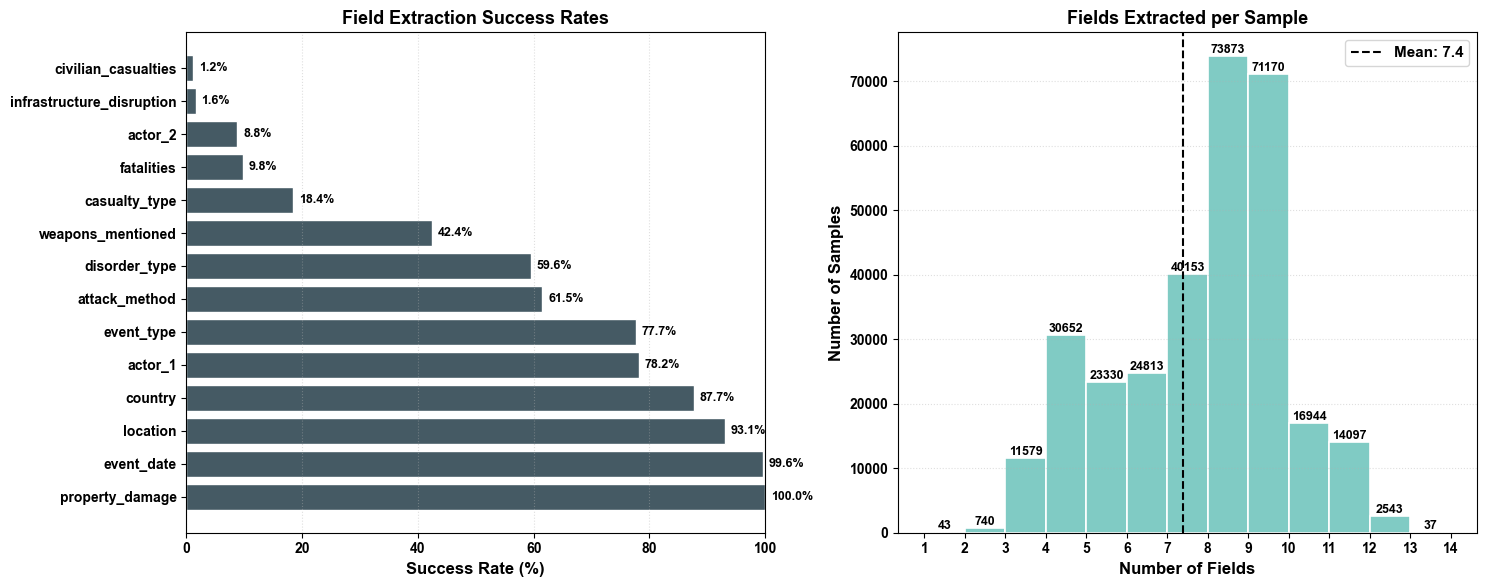


Field Extraction Summary:
Total samples analysed: 309,974
Average fields per sample: 7.4
Samples with 10+ fields: 33,621
Most frequently extracted field: property_damage (100.0%)


In [153]:
def visualise_field_extraction_performance(extraction_results=None, target_fields=None):
    """Visualise field extraction success rates and field count distribution."""

    if extraction_results is None:
        extraction_results = globals().get("extraction_results", [])
    if target_fields is None:
        target_fields = globals().get("TARGET_FIELDS", [])

    if not extraction_results or not target_fields:
        print("Missing data: 'extraction_results' or 'TARGET_FIELDS' not provided.")
        return

    with plt.rc_context({
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.weight": "bold",
        "axes.titlesize": 13,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "axes.labelweight": "bold",
        "xtick.labelsize": 10,
        "ytick.labelsize": 10
    }):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Field Completion Rates
        field_stats = {}
        for field in target_fields:
            non_unknown = sum(1 for sample in extraction_results
                              if sample['extraction'].get(field, 'unknown') != 'unknown')
            field_stats[field] = (non_unknown / len(extraction_results)) * 100

        sorted_fields = sorted(field_stats.items(), key=lambda x: x[1], reverse=True)
        fields, rates = zip(*sorted_fields)

        ax1.barh(fields, rates, color='#455A64', edgecolor='white')
        ax1.set_title('Field Extraction Success Rates')
        ax1.set_xlabel('Success Rate (%)')
        ax1.set_xlim(0, 100)
        ax1.grid(axis='x', linestyle=':', alpha=0.4)

        for i, rate in enumerate(rates):
            ax1.text(rate + 1, i, f'{rate:.1f}%', va='center', fontsize=9, fontweight='bold')

        # Fields per Sample
        fields_per_sample = [
            sum(1 for field in target_fields
                if sample['extraction'].get(field, 'unknown') != 'unknown')
            for sample in extraction_results
        ]

        bins = range(min(fields_per_sample), max(fields_per_sample) + 2)
        counts, _, _ = ax2.hist(fields_per_sample, bins=bins,
                                color='#80CBC4', edgecolor='white', linewidth=1.2)

        mean_val = np.mean(fields_per_sample)
        ax2.axvline(mean_val, color='black', linestyle='--', linewidth=1.5,
                    label=f'Mean: {mean_val:.1f}')

        ax2.set_title('Fields Extracted per Sample')
        ax2.set_xlabel('Number of Fields')
        ax2.set_ylabel('Number of Samples')
        ax2.set_xticks(bins)
        ax2.grid(axis='y', linestyle=':', alpha=0.4)
        ax2.legend()

        for i, count in enumerate(counts):
            if count > 0:
                ax2.text(bins[i] + 0.5, count + 0.5, f'{int(count)}',
                         ha='center', va='bottom', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.show()

    print("\nField Extraction Summary:")
    print(f"Total samples analysed: {len(extraction_results):,}")
    print(f"Average fields per sample: {mean_val:.1f}")
    print(f"Samples with 10+ fields: {sum(1 for x in fields_per_sample if x >= 10):,}")
    most_frequent = max(field_stats.items(), key=lambda x: x[1])
    print(f"Most frequently extracted field: {most_frequent[0]} ({most_frequent[1]:.1f}%)")

visualise_field_extraction_performance(extraction_results, TARGET_FIELDS)

### Strategic Subset Creation and Export

A final set of 25.000 samples is selected from validated entries, prioritising field completeness, note quality, and presence of less common fields.

#### Subset Selection

Each sample is scored using:
- **Field coverage**: Number of valid fields (out of 14).
- **Quality bonus**: Based on note quality score.
- **Rare field bonus**: Applied to fields like `disorder_type` and `civilian_casualties`.

The top-ranked samples are selected. Summary statistics include average field count and number of samples with 10 or more fields.

#### Export Format

Two files are generated:
- **`ACLED_finetuning_dataset.jsonl`** – Each entry includes:
  - A structured `instruction` prompt based on the original conflict note
  - A JSON `output` with extracted fields
  - A unique sample ID and field count
- **`dataset_metadata.json`** – Contains field coverage stats, geographic distribution, and export metadata.

#### Dataset Summary

| **Metric**                           | **Value**                      | **Explanation**                                                                 |
|-------------------------------------|--------------------------------|----------------------------------------------------------------------------------|
| Raw samples (initial dataset)       | 309.974                        | Total ACLED event records from Eastern and Central Europe, and the Baltic States |
| Valid samples after filtering       | 219.180                        | Records retained after applying regional and quality-based filtering (70.7% of total) |
| Training subset size                | 25.000                         | High-quality samples selected for fine-tuning (11.4% of filtered data)          |
| Average fields per training sample  | 10.8 / 14                      | Mean number of successfully extracted fields per training example               |
| Samples with all 14 fields          | 0                              | No training sample contained a complete set of fields                          |
| Samples with ≥10 fields             | 24.907                         | 99.6% of the training set contains ten or more extracted fields                |
| Exported dataset                    | `ACLED_finetuning_dataset.jsonl` | Instruction–output pairs prepared for fine-tuning                              |
| Metadata file                       | `dataset_metadata.json`        | Contains field-level statistics, examples, and geographic breakdown             |
| Output directory                    | `ACLED_data_export`            | Location of all exported data files and visual outputs                          |
| Sample ID (first entry)             | `acled_00001`                  | Format used to uniquely identify each training example                          |
| Fields extracted (first sample)     | 13                             | First sample contains 13 out of 14 fields (92.9% field coverage)                |

In [154]:
def strategic_subset(samples, target_size=25000):
    """Strategically selected subset prioritising highest quality notes that cover more than 10 fileds."""
    
    print(f"\nCreating strategic subset from {len(samples):,} valid samples")
    print(f"Target: {target_size:,} samples with maximum field coverage")
    
    scored_samples = []
    
    for sample in samples:
        extraction = sample['extraction']
        
        # Count valid fields
        valid_fields = sum(1 for field, value in extraction.items() 
                          if value != "unknown" and field in TARGET_FIELDS)
        
        # Calculate scores
        completeness_score = valid_fields
        quality_bonus = sample['metadata']['quality_score'] * 0.5
        
        # Bonus for rare fields
        rare_field_bonus = 0
        rare_fields = ['disorder_type', 'infrastructure_disruption', 'civilian_casualties', 'casualty_type']
        for field in rare_fields:
            if extraction.get(field) != "unknown":
                rare_field_bonus += 2.0
        
        total_score = completeness_score + quality_bonus + rare_field_bonus
        scored_samples.append((sample, completeness_score, total_score))
    
    # Sort by score and select top samples
    scored_samples.sort(key=lambda x: x[2], reverse=True)
    selected_samples = [item[0] for item in scored_samples[:target_size]]
    
    # Analysis
    field_counts = [item[1] for item in scored_samples[:target_size]]
    avg_fields = sum(field_counts) / len(field_counts)
    complete_samples = sum(1 for count in field_counts if count == 14)
    
    print(f"Subset Analysis:")
    print(f"Selected: {len(selected_samples):,} samples")
    print(f"Average fields per sample: {avg_fields:.1f}/14")
    print(f"Samples with all 14 fields: {complete_samples:,}")
    print(f"Samples with ≥10 fields: {sum(1 for c in field_counts if c >= 10):,}")
    
    return selected_samples

def export_curated_dataset(samples):
    
    print(f"\nExporting {len(samples):,} samples to clean JSONL format")
    
    # Convert to export format
    export_data = []
    for i, sample in enumerate(samples):
        clean_extraction = {}
        for field in TARGET_FIELDS:
            clean_extraction[field] = sample['extraction'].get(field, "unknown")
        
        export_entry = {
            "instruction": f"Extract relevant information from this conflict event report:\n\n{sample['note']}",
            "output": json.dumps(clean_extraction, ensure_ascii=False),
            "id": f"acled_{i+1:05d}",
            "fields_extracted": len([v for v in clean_extraction.values() if v != "unknown"])
        }
        export_data.append(export_entry)
    
    dataset_path = os.path.join(export_dir, "ACLED_finetuning_dataset.jsonl")
    with open(dataset_path, 'w', encoding='utf-8') as f:
        for entry in export_data:
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')
    
    field_counts = [e['fields_extracted'] for e in export_data]
    country_dist = defaultdict(int)
    for sample in samples:
        country = sample['extraction'].get('country', sample['metadata']['source_country'])
        country_dist[country] += 1
    
    metadata = {
        'dataset_info': {
            'creation_date': datetime.now().isoformat(),
            'total_samples': len(export_data),
            'source': 'ACLED Processing Pipeline',
            'target_fields': TARGET_FIELDS,
            'geographic_scope': TARGET_COUNTRIES
        },
        'quality_statistics': {
            'average_fields_per_sample': sum(field_counts) / len(field_counts),
            'samples_with_all_14_fields': sum(1 for c in field_counts if c == 14),
            'samples_with_10_plus_fields': sum(1 for c in field_counts if c >= 10)
        },
        'field_coverage': {
            field: {
                'count': sum(1 for s in samples if s['extraction'].get(field) != "unknown"),
                'percentage': (sum(1 for s in samples if s['extraction'].get(field) != "unknown") / len(samples)) * 100,
                'examples': list(set([str(s['extraction'].get(field)) for s in samples 
                                    if s['extraction'].get(field) != "unknown"]))[:10]
            }
            for field in TARGET_FIELDS
        },
        'geographic_distribution': dict(country_dist)
    }
    
    metadata_path = os.path.join(export_dir, "dataset_metadata.json")
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    print(f"Dataset exported: {dataset_path}")
    print(f"Metadata exported: {metadata_path}")
    
    return export_data, metadata

print("=" * 70)
print("STRATEGIC SUBSET CREATION & EXPORT")
print("=" * 70)

strategic_samples = strategic_subset(valid_samples, target_size=25000)
export_data, metadata = export_curated_dataset(strategic_samples)

print(f"\nValidation Summary:")
print(f"Total samples: {len(export_data):,}")
print(f"Average fields per sample: {sum(e['fields_extracted'] for e in export_data) / len(export_data):.1f}/14")
print(f"Export directory: {export_dir}")
print(f"Files created: ACLED_finetuning_dataset.jsonl, dataset_metadata.json")

# ACLED sample taken from the curated dataset
if export_data:
    sample = export_data[0]
    print(f"\nSample entry:")
    print(f"ID: {sample['id']}")
    print(f"Fields extracted: {sample['fields_extracted']}")
    print(f"Instruction: {sample['instruction'][:100]}")
    
    parsed_output = json.loads(sample['output'])
    print(f"Output preview:")
    for field, value in list(parsed_output.items())[:5]:
        if value != "unknown":
            print(f"  {field}: {value}")

print(f"\nExport complete. Dataset ready for fine-tuning.")

STRATEGIC SUBSET CREATION & EXPORT

Creating strategic subset from 219,180 valid samples
Target: 25,000 samples with maximum field coverage
Subset Analysis:
Selected: 25,000 samples
Average fields per sample: 10.8/14
Samples with all 14 fields: 0
Samples with ≥10 fields: 24,907

Exporting 25,000 samples to clean JSONL format
Dataset exported: ACLED_data_export/ACLED_finetuning_dataset.jsonl
Metadata exported: ACLED_data_export/dataset_metadata.json

Validation Summary:
Total samples: 25,000
Average fields per sample: 10.8/14
Export directory: ACLED_data_export
Files created: ACLED_finetuning_dataset.jsonl, dataset_metadata.json

Sample entry:
ID: acled_00001
Fields extracted: 13
Instruction: Extract relevant information from this conflict event report:

On 8 July 2024, Russian forces launch
Output preview:
  event_date: 8 July 2024
  country: ukraine
  location: ['Okhmatdyt', 'Kyiv']
  event_type: remote_violence
  actor_1: Russian military forces

Export complete. Dataset ready for fi

### Test Set Creation

To support objective evaluation of the fine-tuned model, a **held-out test set of 400 samples** was curated from the ACLED dataset, focusing on recent events between **2022 and 2024**. The test set creation process is managed by the function `create_acled_test_dataset()` and involves the following steps:

**Step 1 – Temporal Filtering**:

Only events dated **after 2022** were considered to prioritise **recent and contextually relevant** data. If insufficient samples were found, the function defaulted to the **entire dataset** to ensure coverage.

**Step 2 – Proportional Geographic Sampling**:

To preserve regional diversity, samples were drawn **proportionally across countries** based on their occurrence frequency in the filtered data. This prevents overrepresentation of any single country in the test set.

**Step 3 - Balancing Strategy**:

The country-level allocations were then **adjusted** to fit the target size of 400 samples. If the proportional distribution resulted in a shortfall, **fallback sampling** was used to ensure the dataset reached full size without duplicating entries.

**Step 4 - Output**:

The final test set:
- Contains **400 unique samples** from 2022–2024,
- Includes only the `notes` field for evaluation,
- Is exported as `ACLED_test_dataset.csv`.

#### Summary Table

| **Metric**            | **Value** | **Explanation**                                                                 |
|------------------------|----------|----------------------------------------------------------------------------------|
| Held-out test set      | 400      | Samples reserved for structured model evaluation (0.18% of valid samples)       |

This **balanced and chronologically recent** test set serves as a representative benchmark for evaluating the structured event extraction model.

In [155]:
def create_acled_test_dataset(df, size=400):
    """200 test samples from ACLED data (2022-2024), focusing on geographic diversity."""

    df_filtered = df[df['event_date'] >= '2022-01-01'].copy()

    if len(df_filtered) == 0:
        print("No data available for 2022-2024 period, using full dataset.")
        df_filtered = df.copy()
    if len(df_filtered) < size:
        print(f"Only {len(df_filtered)} samples available — using all available data.")
        size = len(df_filtered)

    test_samples = []

    # Proportional allocation of samples across countries
    countries = df_filtered['country'].value_counts()
    samples_per_country = {}

    for country in countries.index:
        proportion = countries[country] / len(df_filtered)
        allocated = max(1, int(size * proportion))
        samples_per_country[country] = min(allocated, countries[country])

    # Adjust allocations if they exceed total desired size
    total_allocated = sum(samples_per_country.values())
    if total_allocated > size:
        scale_factor = size / total_allocated
        for country in samples_per_country:
            samples_per_country[country] = max(1, int(samples_per_country[country] * scale_factor))

    # Sampling from each country
    for country, count in samples_per_country.items():
        country_data = df_filtered[df_filtered['country'] == country]
        sampled = country_data.sample(n=count, random_state=42) if len(country_data) >= count else country_data

        for _, row in sampled.iterrows():
            if len(test_samples) >= size:
                break
            test_samples.append({'notes': row['notes']})

    # Fill remaining slots if needed
    remaining = size - len(test_samples)
    if remaining > 0:
        remaining_data = df_filtered[~df_filtered.index.isin(df_filtered.index[:len(test_samples)])]
        additional = remaining_data.sample(n=min(remaining, len(remaining_data)), random_state=42)
        for _, row in additional.iterrows():
            test_samples.append({'notes': row['notes']})

    return test_samples[:size]

test_dataset = create_acled_test_dataset(df, size=400)

test_df = pd.DataFrame(test_dataset)
test_file_path = os.path.join(export_dir, "ACLED_test_dataset.csv")
test_df.to_csv(test_file_path, index=False, encoding='utf-8')

print(f"Created {len(test_dataset)}-sample ACLED test dataset")
print(f"Saved to: {test_file_path}")

print("\nSample entries:")
for i in range(min(3, len(test_dataset))):
    print(f"   {test_dataset[i]['notes'][:80]}")

Created 400-sample ACLED test dataset
Saved to: ACLED_data_export/ACLED_test_dataset.csv

Sample entries:
   On 6 November 2023, Russian forces shelled Ukrainian military positions in Hulia
   On 8 January 2025, Russian forces carried out airstrikes and shelled Dudchany, K
   Defusal: On 15 March 2024, Russian air forces bombed Selydove, Donetsk. The bomb
